In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import importlib
import utils
import attention
import glob
from collections import defaultdict

import seaborn as sns
import pandas as pd

# Number of Parameters in Each Model

In [25]:

outdir = "/scratch/gpfs/qanguyen/renorm"
arches = ["mlp", "cnn", "cnn_chan_1-16", "cnn_chan_1-1", "alexnet", "vgg11", "attn", "attn_no_pe"]
for arch in arches:
    for f in glob.glob(f"{outdir}/{arch}_shuffled_True*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        shapes = [v.ravel().shape for p, v in record["model"]]
        print(arch, torch.sum(torch.tensor(shapes)))

mlp tensor(328510)
cnn tensor(62006)
cnn_chan_1-16 tensor(59626)
cnn_chan_1-1 tensor(14236)
alexnet tensor(57044810)
vgg11 tensor(128807306)
attn tensor(8458250)
attn_no_pe tensor(8458250)


# Train & Test Loss, Accuracy

Number of runs alexnet True 1
Number of runs alexnet False 1
[3.21698040263668] 1
[1.8926814430078882] 1


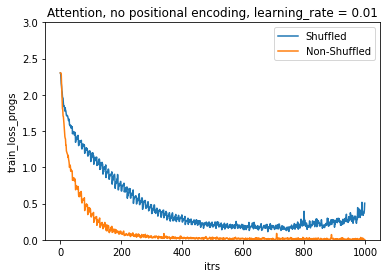

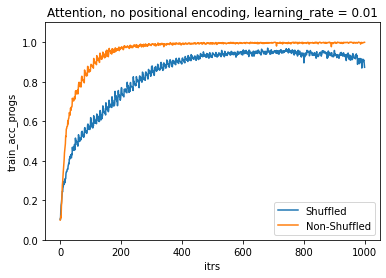

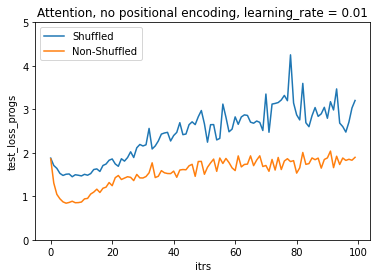

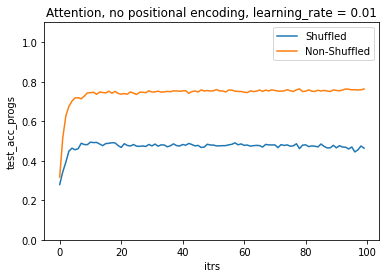

model_True_test_losses [3.21698040263668]
model_False_test_losses [1.8926814430078882]


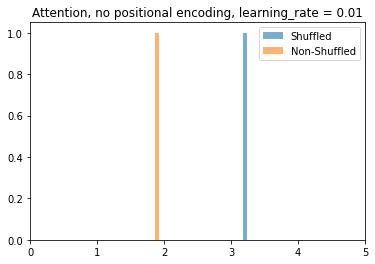

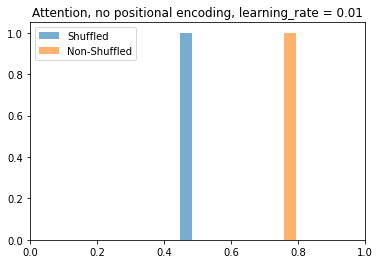

In [2]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    #outdir = "/scratch/gpfs/qanguyen/renorm"
    outdir = "/gpfs/milgram/scratch60/turk-browne/an633/renorm_quench"
    test_losses = []
    test_accs = []
    lrs = []
    itrs = []
    train_loss_progs = []
    train_acc_progs = []
    testlosses_dict = []
    
    test_itrs = []
    test_loss_progs = []
    test_acc_progs = []
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        itr, train_loss_prog = list(zip(*enumerate(record["metrics"]["train_loss_prog"])))
        if len(itr) > 500:
            test_losses.append(record["metrics"]["test_loss"])
            test_accs.append(record["metrics"]["test_accuracy"])
            itrs.extend(itr)
            train_loss_progs.extend(train_loss_prog)
            testlosses_dict.extend([record["metrics"]["test_loss"]] * len(itr))
            
        itr, train_acc_prog = list(zip(*enumerate(record["metrics"]["train_acc_prog"])))
        if len(itr) > 500:
            train_acc_progs.extend(train_acc_prog)
            
        itr, test_loss_prog = list(zip(*enumerate(record["metrics"]["test_loss_prog"])))
        test_itrs.extend(itr)
        test_loss_progs.extend(test_loss_prog)
        
        itr, test_acc_prog = list(zip(*enumerate(record["metrics"]["test_acc_prog"])))
        test_acc_progs.extend(test_acc_prog)
        
    print("Number of runs", model_name, shuffled, len(test_losses))
    train_df = pd.DataFrame.from_dict(dict(itrs = itrs, 
                                                         train_loss_progs = train_loss_progs, 
                                                         train_acc_progs = train_acc_progs,
                                                         testlosses_dict = testlosses_dict))
    test_df = pd.DataFrame.from_dict(dict(itrs = test_itrs, 
                                                         test_loss_progs = test_loss_progs, 
                                                         test_acc_progs = test_acc_progs))
    return test_losses, test_accs, lrs, train_df, test_df
    
    
def plot(model_name, title, extra=""):
    model_True_test_losses, model_True_test_accs, _, shuffletrainloss, shuffletestloss  = get_record(model_name = model_name, shuffled = "True", extra = extra)
    model_False_test_losses, model_False_test_accs, _, non_shuffletrainloss, non_shuffletestloss = get_record(model_name = model_name, shuffled = "False", extra = extra)
    model_True_test_losses = [i for i in model_True_test_losses if not np.isnan(i)]
    
    #model_True_test_losses = [i for i in model_True_test_losses if i < np.sort(model_True_test_losses)[-1]]
    #model_False_test_losses = [i for i in model_False_test_losses if i < np.sort(model_False_test_losses)[-1]]
    print(model_True_test_losses, len(model_True_test_losses))
    print(model_False_test_losses, len(model_False_test_losses))

    sns.lineplot(x = "itrs", y="train_loss_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_loss_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 3)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="train_acc_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_acc_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
                                     
    sns.lineplot(x = "itrs", y="test_loss_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_loss_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 5)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="test_acc_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_acc_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
    
    print("model_True_test_losses", model_True_test_losses)
    print("model_False_test_losses", model_False_test_losses)
    plt.hist(model_True_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 5)
    plt.title(title)
    plt.legend()
    plt.show()
    

    plt.hist(model_True_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 1)
    plt.title(title)
    plt.legend()
    plt.show()

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

plot("alexnet", title = "Attention, no positional encoding, learning_rate = 0.01", extra="lr_0.01")

# plot("vgg11", title = "VGG, learning_rate = 0.001", extra="lr_0.001")

# plot("vgg11", title = "VGG, learning_rate = 0.01", extra="lr_0.01")

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

# plot("attn_no_pe", title = "Attention, no positional encoding")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels")

# plot("mlp", title = "MLP", extra="lr_0.001")

# plot("mlp", title = "MLP", extra="lr_0.01")


## Holding the shuffle permutation fixed

[[[0.4496173  0.52663434 0.47668734]
  [0.54987353 0.55575544 0.5160403 ]
  [0.49554032 0.5608506  0.5492583 ]
  [0.5134214  0.52657974 0.4315286 ]
  [0.43549526 0.510604   0.5265976 ]
  [0.55574983 0.48856792 0.45850074]
  [0.5135425  0.48764232 0.46054152]
  [0.46217045 0.52114636 0.46102372]
  [0.5325329  0.5497944  0.5467843 ]
  [0.5329117  0.5293136  0.46599266]
  [0.504152   0.5038543  0.47570086]]

 [[0.5091302  0.50606674 0.55340743]
  [0.5502989  0.5440201  0.5395487 ]
  [0.53897417 0.5202846  0.4036138 ]
  [0.5355207  0.44556168 0.5176998 ]
  [0.48846766 0.5544489  0.5427135 ]
  [0.5677274  0.53840053 0.47507572]
  [0.45627674 0.4762116  0.4716182 ]
  [0.47201705 0.46289653 0.49129343]
  [0.54394644 0.5046541  0.46903798]
  [0.5069712  0.5397295  0.5476844 ]
  [0.49559498 0.5559115  0.5402565 ]]

 [[0.5109227  0.5133579  0.49632737]
  [0.481006   0.4987156  0.5582062 ]
  [0.5232589  0.5462615  0.4835016 ]
  [0.41105163 0.46870846 0.48534986]
  [0.5309055  0.5225289  0.5383739

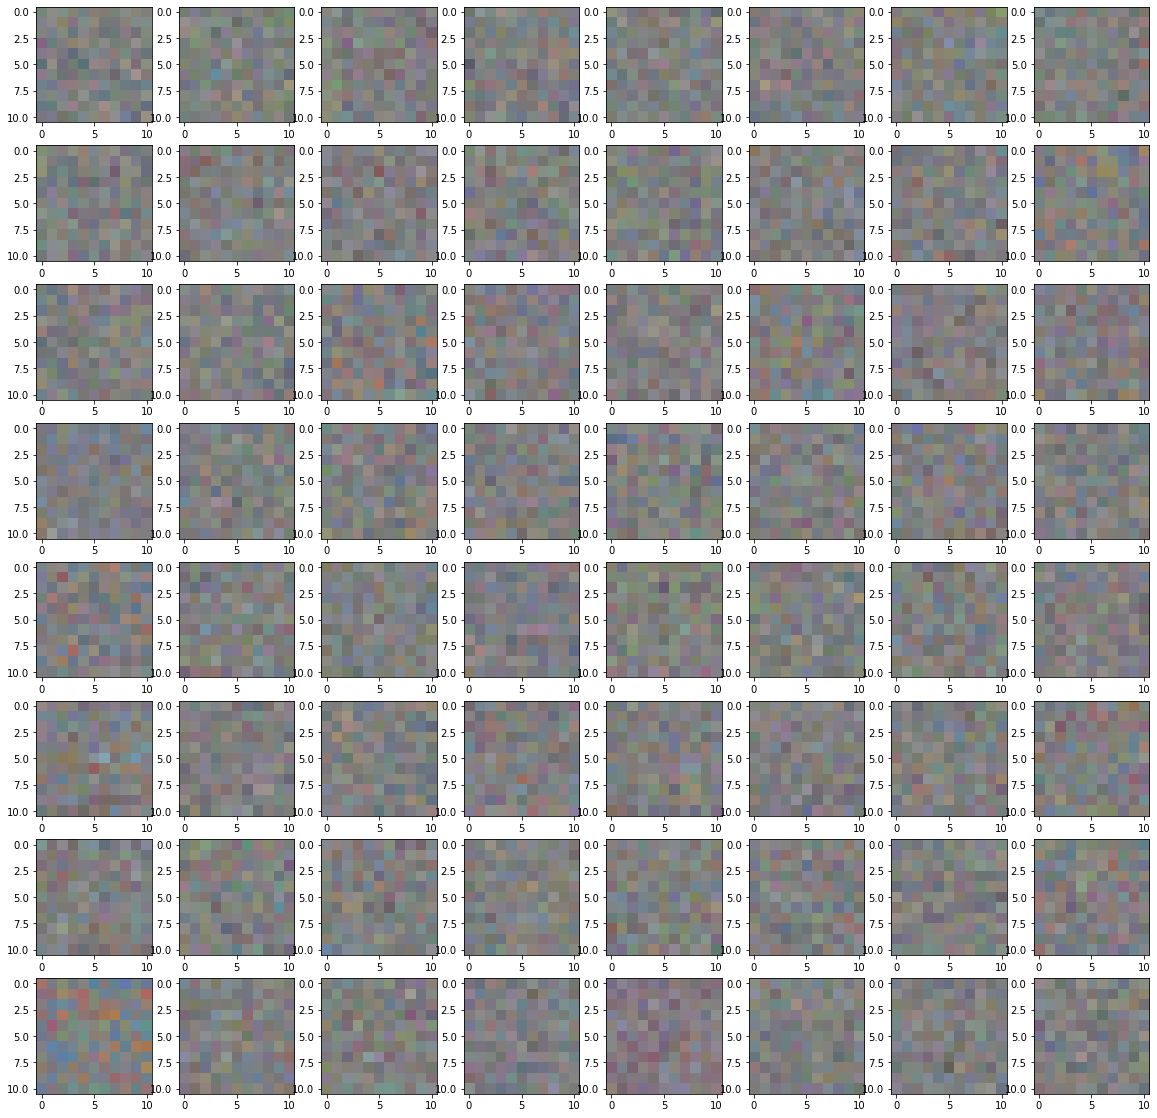

NameError: name 'model' is not defined

In [16]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    #outdir = "/scratch/gpfs/qanguyen/renorm"
    outdir = "/gpfs/milgram/scratch60/turk-browne/an633/renorm_quench"
    
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:2]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            if _ == 0:
                print(v)
            plt.imshow(v)
            #pars[_].append(v)
        plt.show()
        
        print(model)
        break
get_record("alexnet", shuffled=True)

# Average the filters for different quenched transformations 


In [ ]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    import warnings
    warnings.filterwarnings("ignore")
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:200]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}
        param_dict['conv1.weight'] = param_dict['conv1.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        #plt.figure(figsize=(10,5))
        for _ in range(6):
            #plt.subplot(1, 6, _+1)
            v = param_dict['conv1.weight'][_].detach().cpu().numpy()
            #plt.imshow(v)
            pars[_].append(v)
        #print(param_dict['conv1.weight'])
        #plt.show()
    plt.figure(figsize=(10,5))
    i = 1
    stds = []
    for _, convs in pars.items():
        plt.subplot(1, 6, i)
        m = torch.tensor(convs).mean(dim=0)
        s = torch.tensor(convs).std(dim=0)
        #print(m)
        plt.imshow(m,vmin=0,vmax=1)
        i += 1
        stds.extend(s.numpy().ravel())
    plt.show()
    plt.hist(stds)
    plt.xlim(0.1, 0.9)
    plt.show()

get_record(model_name = "cnn", shuffled=True)
get_record(model_name = "cnn", shuffled=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

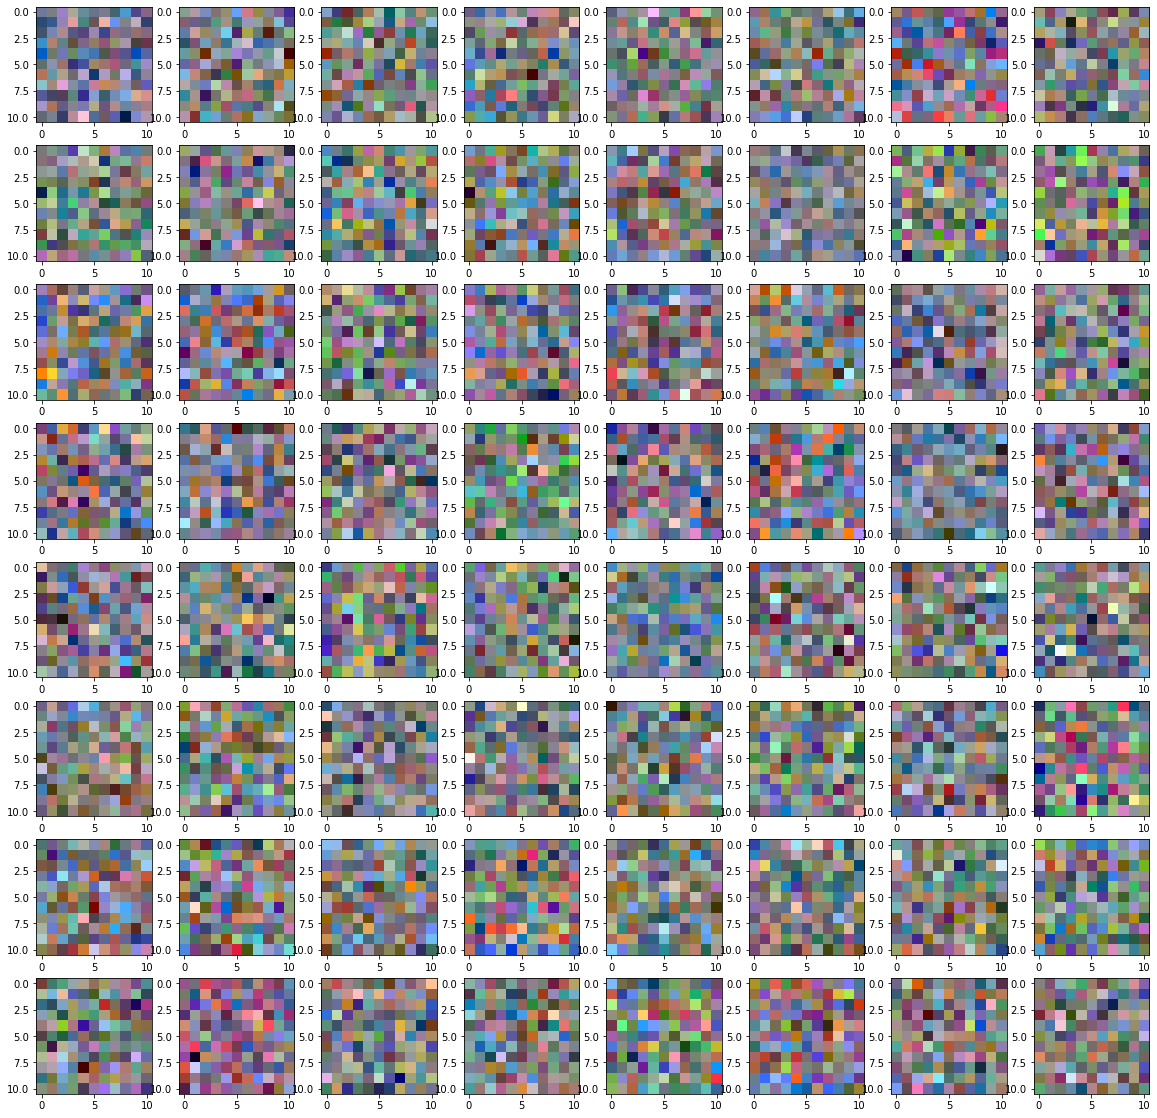

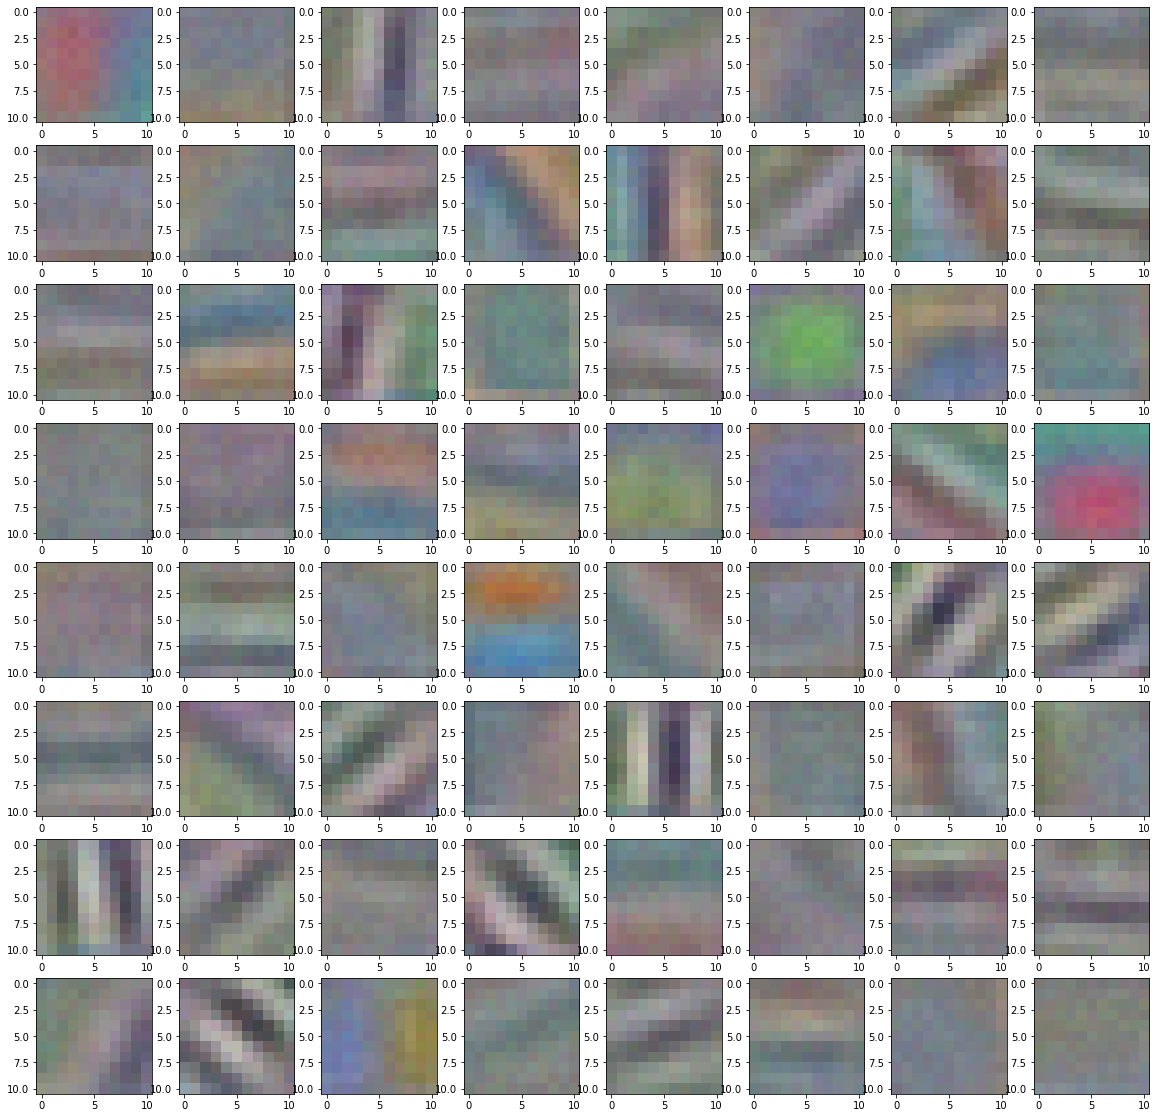

In [66]:
importlib.reload(utils)
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            plt.imshow(v)
            pars[_].append(v)
        plt.show()
import warnings

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)

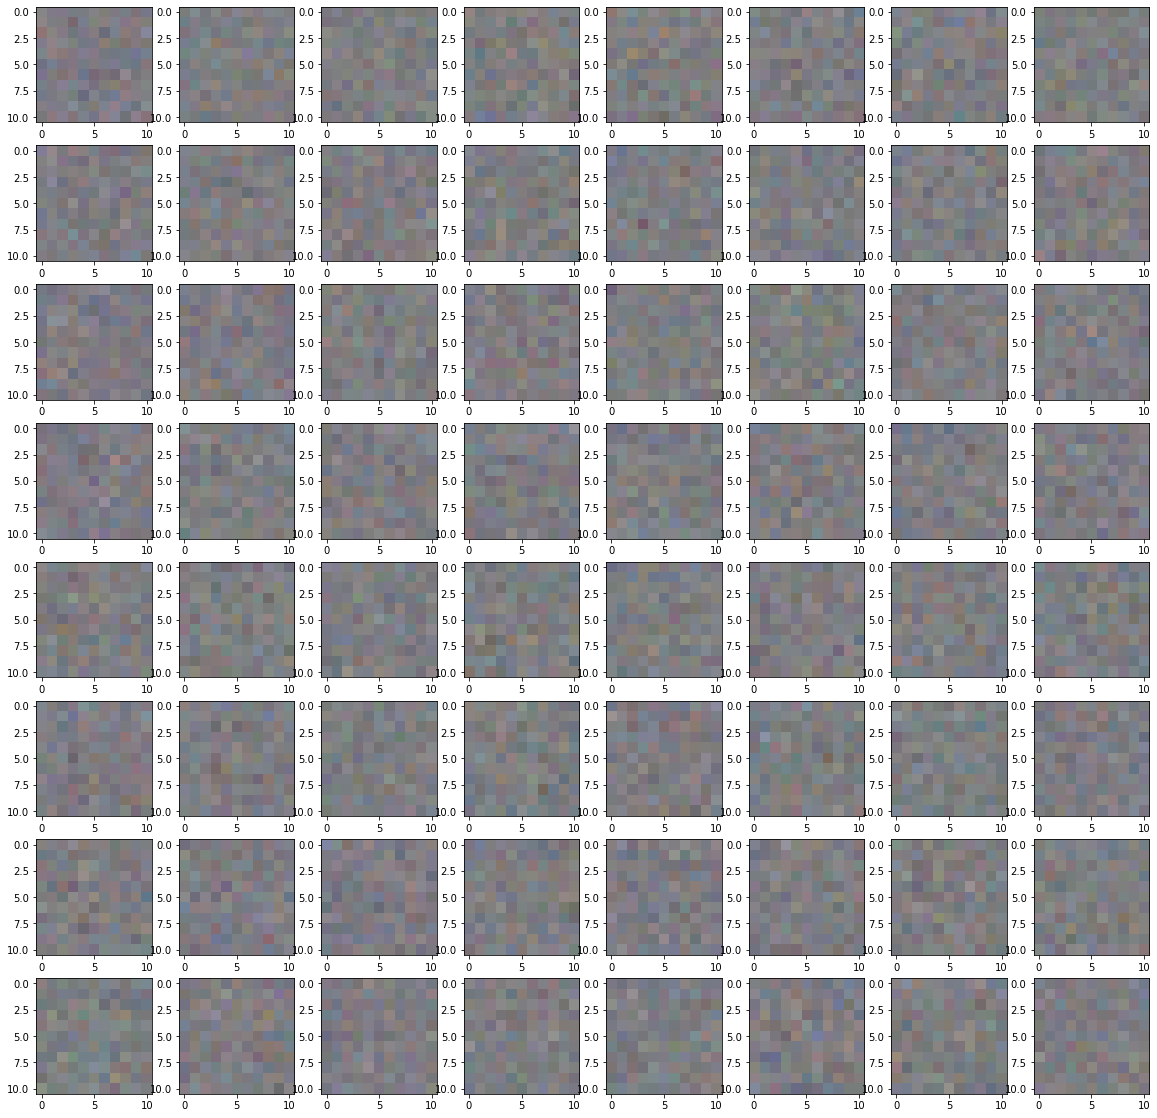

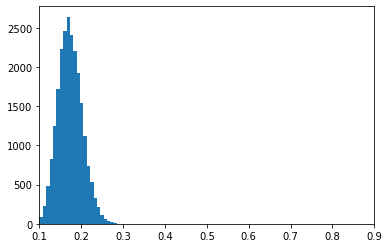

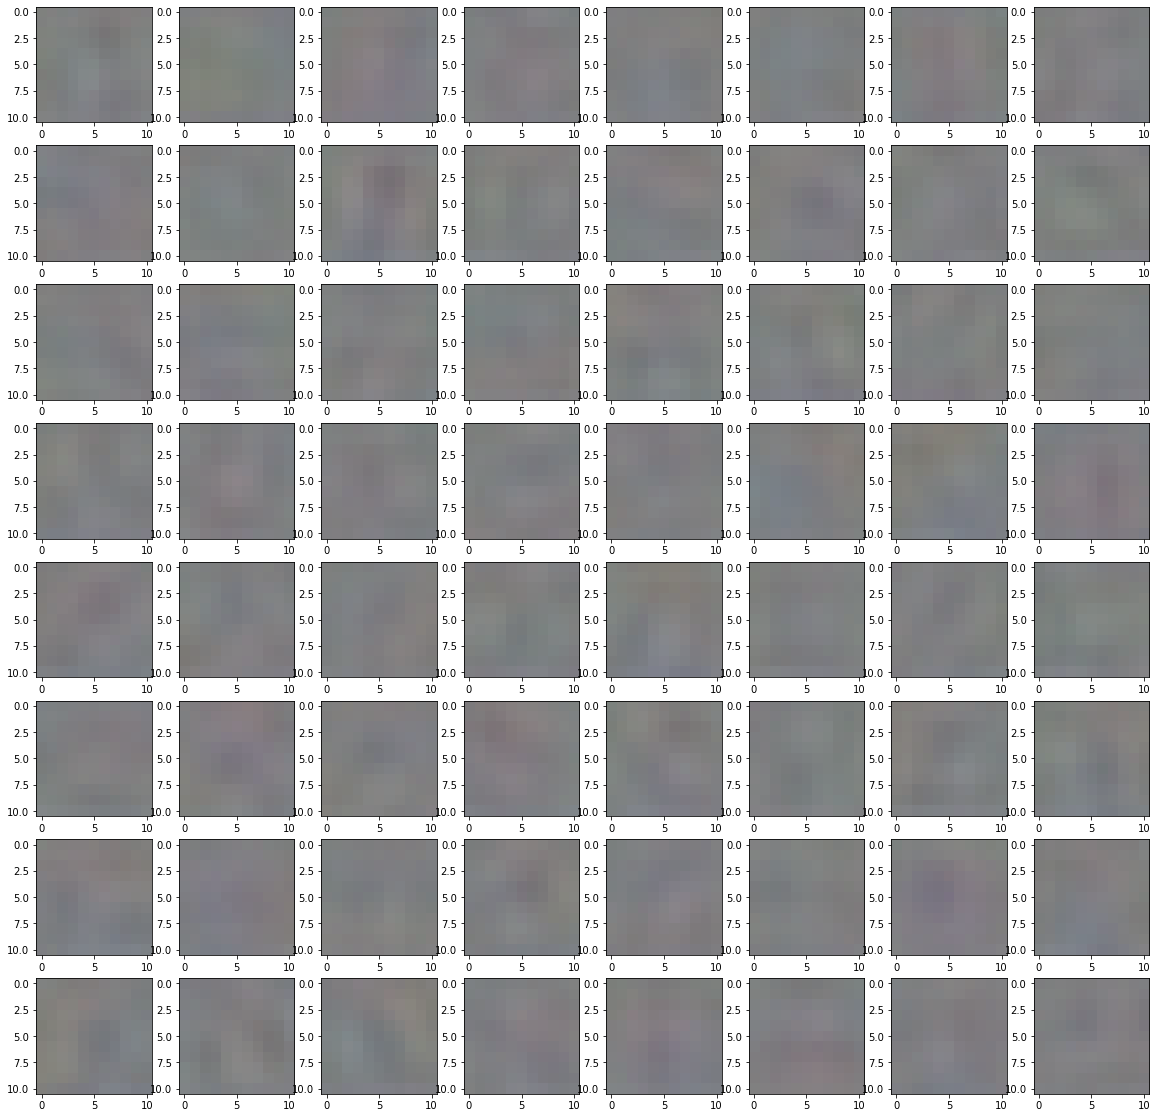

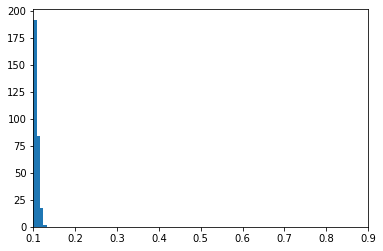

In [72]:
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    import warnings
    warnings.filterwarnings("ignore")
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:200]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        for _ in range(64):
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            pars[_].append(v)
    plt.figure(figsize=(20,20))
    i = 1
    stds = []
    for _, convs in pars.items():
        plt.subplot(8, 8, i)
        m = torch.tensor(convs).mean(dim=0)
        s = torch.tensor(convs).std(dim=0)
        #print(m)
        plt.imshow(m,vmin=0,vmax=1)
        i += 1
        stds.extend(s.numpy().ravel())
    plt.show()
    plt.hist(stds,bins=np.linspace(0.1,0.9,100))
    plt.xlim(0.1, 0.9)
    plt.show()

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)

# Hold quenched transform fixed and run multiple runs on that transformation

In [6]:
importlib.reload(utils)
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*"):
        record = utils.load_file_pickle(f)
        print(record)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            plt.imshow(v)
            pars[_].append(v)
        plt.show()
import warnings

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)a

SyntaxError: invalid syntax (3481618575.py, line 23)

# Polynomial Regression

## Models (MLP_small, resnetsmall)

/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_14_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664751062.974683.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664748096.510145.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_14_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664745074.98025.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_22_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664745108.597752.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_26_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664745084.080042.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_18_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664748040.435527.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order

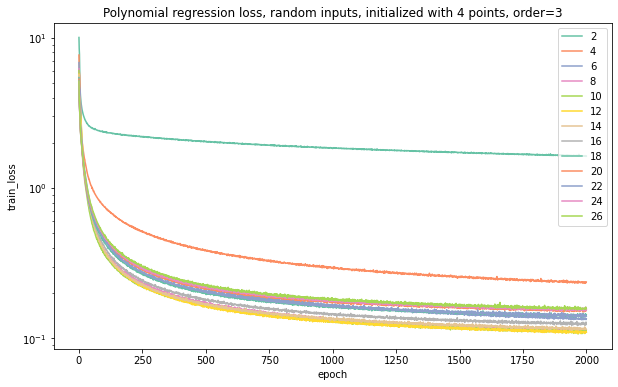

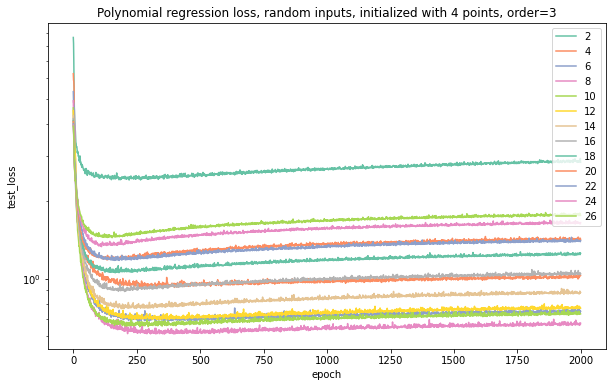

In [8]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = 3, input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, initialized with 4 points, order=3", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir = "/scratch/gpfs/qanguyen/poly_learncurve")


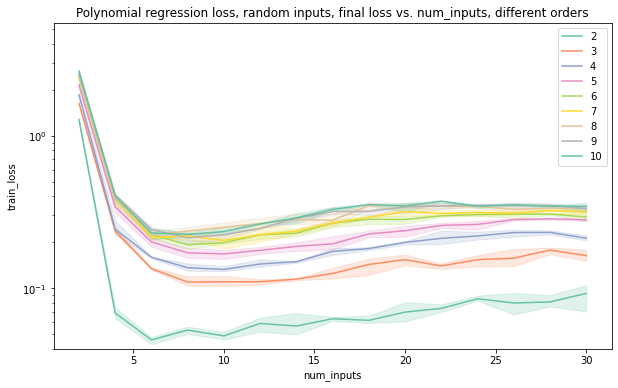

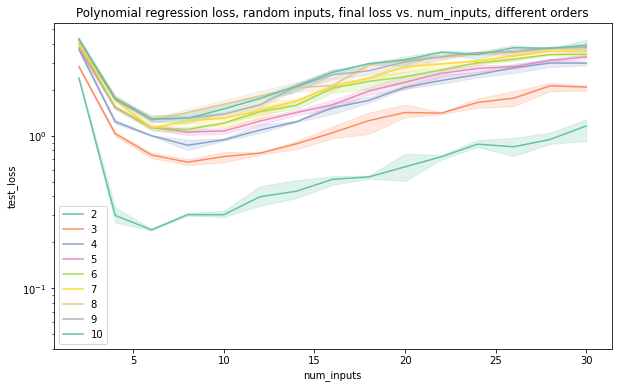

In [28]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        pars["order"].append(record["data_params"]["order"])
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="train_loss", hue="order",  palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="test_loss", hue="order", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, different orders", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir = "/scratch/gpfs/qanguyen/poly_learncurve")


### Plot epochs vs. loss

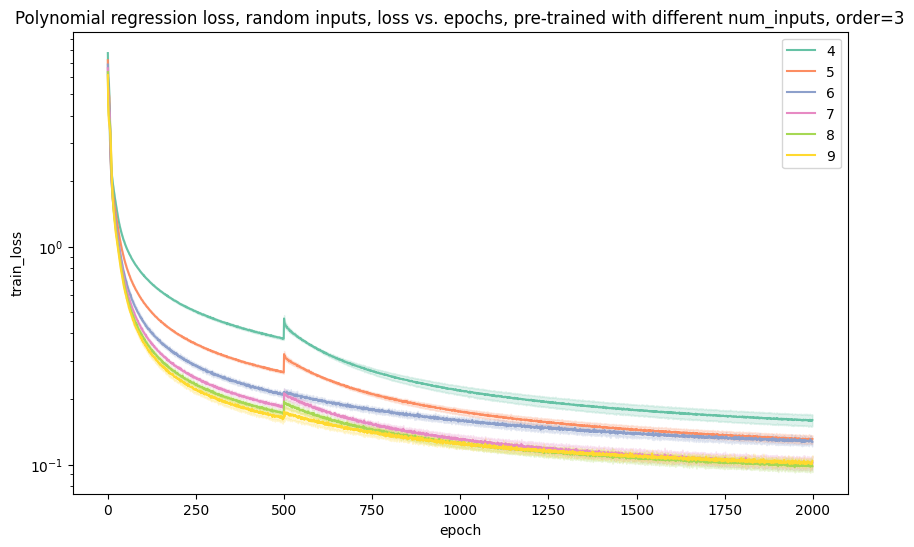

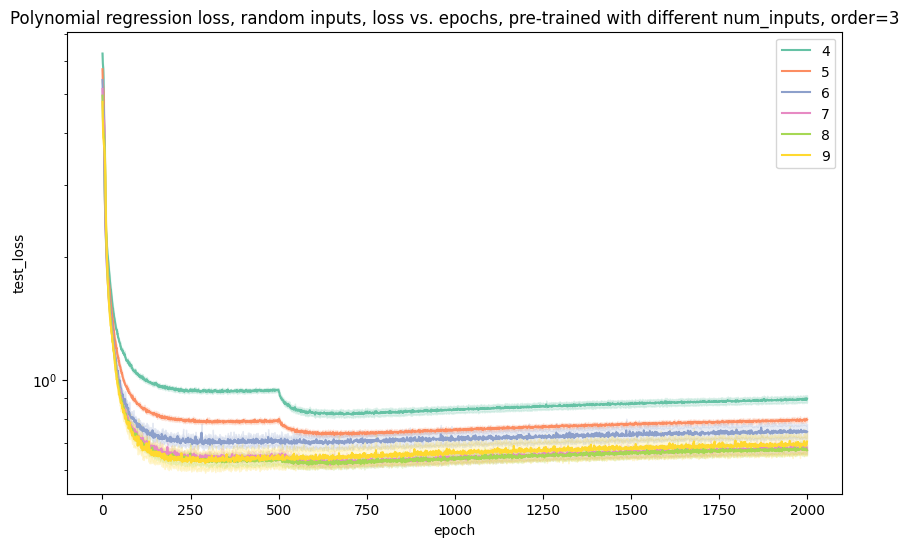

In [21]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
         
        #pars["num_inputs"].append(record["data_params"]["num_inputs"])
        # pars["num_inputs_kept"].append(record["train_params"]["num_inputs_kept"])
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["train_params"]["num_inputs_kept"])] * len(record["metrics"]["train_loss_prog"]))
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small_silence", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, loss vs. epochs, pre-trained with different num_inputs, order=3", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir =  "./poly_freeze")

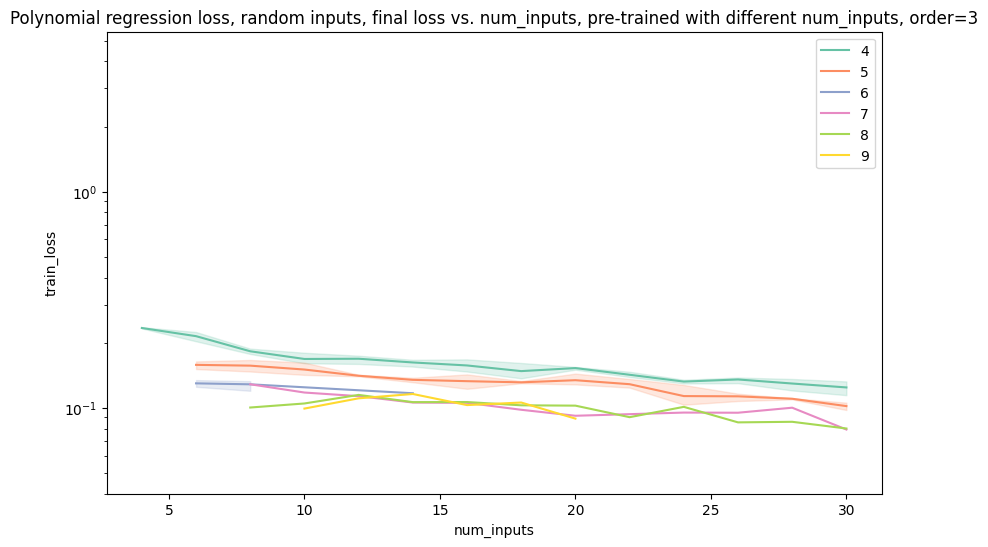

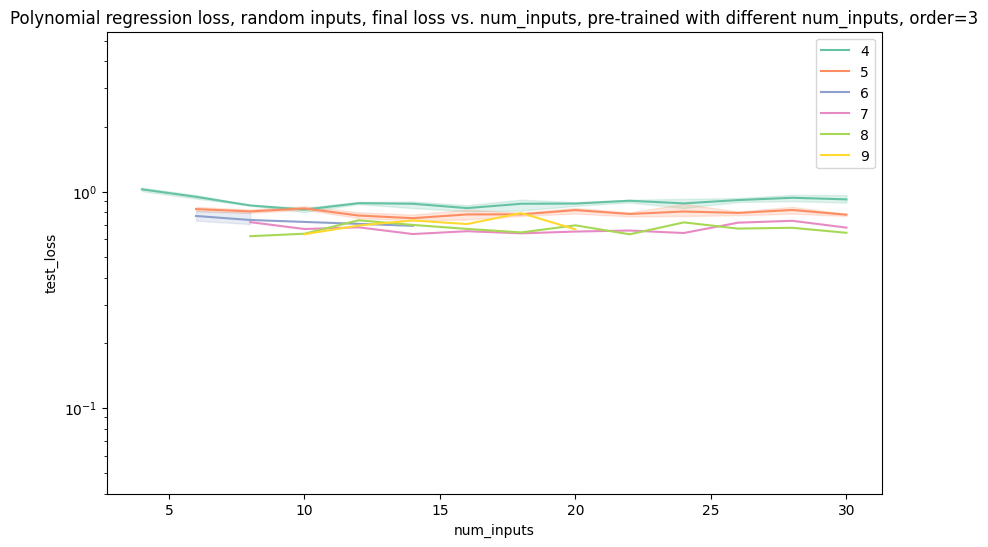

In [13]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        pars["num_inputs_kept"].append(record["train_params"]["num_inputs_kept"])
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="train_loss", hue="num_inputs_kept",  palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="test_loss", hue="num_inputs_kept", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small_silence", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, pre-trained with different num_inputs, order=3", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir = "./poly_freeze")

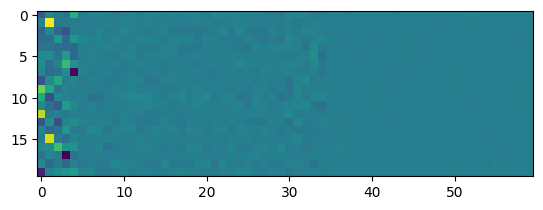

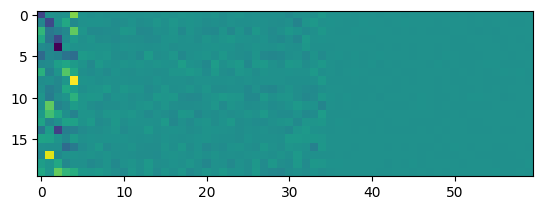

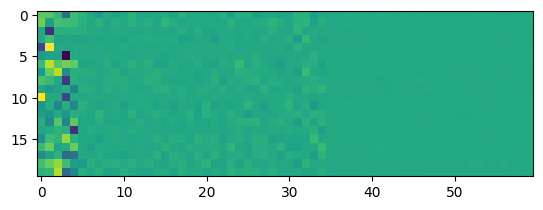

defaultdict(<class 'list'>, {'train_loss': [0.09748317609179993, 0.10538911804252742, 0.10198916012079132], 'test_loss': [0.7887977319104331, 0.7839827975448297, 0.7713834251068077], 'num_inputs': [30, 30, 30], 'num_inputs_kept': [5, 5, 5]})


In [17]:
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        if record["train_params"]["num_inputs_kept"] not in num_inputs_kept_list:
             continue
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        pars["num_inputs_kept"].append(record["train_params"]["num_inputs_kept"])
        img = record["model"].fc1.weight.cpu().detach().numpy()[:20]
        #print(img[:5])
        plt.imshow(img)
        plt.show()
    print(pars)
# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small_silence", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, pre-trained with different num_inputs, order=3", 
           num_inputs_kept_list = [5],
           num_inputs_list=[30], 
           outdir = "./poly_freeze")

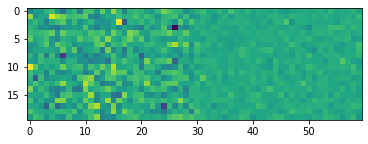

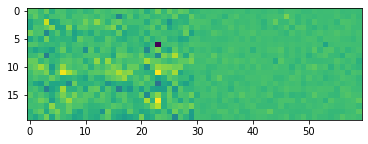

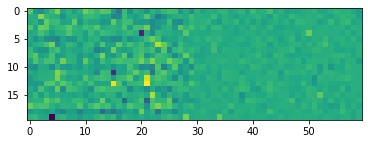

defaultdict(<class 'list'>, {'train_loss': [0.1784662097996595, 0.15113789842901182, 0.1611216950933544], 'test_loss': [2.137012933589974, 1.9713516545539, 2.1378392528514474], 'num_inputs': [30, 30, 30]})


In [47]:
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        img = record["model"].fc1.weight.cpu().detach().numpy()[:20]
        #print(img[:5])
        plt.imshow(img)
        plt.show()
    print(pars)
# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, pre-trained with different num_inputs, order=3", 
           num_inputs_list=[30], 
           outdir = "/scratch/gpfs/qanguyen/poly_learncurve")

In [31]:
import polynomial
d = polynomial.PolynomialData(num_examples = 100, num_inputs = 40, order = 5, random_coefs=True, 
                 input_strategy="repeat", is_online = False, noise = 0.0, output_strategy = "evaluate_at_0",
                 sample_strategy="roots")


rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting
rooting


In [35]:
c  = zip(  [v[0].numpy()[60:80] for v in d],[v[0].numpy()[100:120] for v in d]  )
print( [a==b for a, b in c])

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), array([ True,  True, 

### L1 regularization

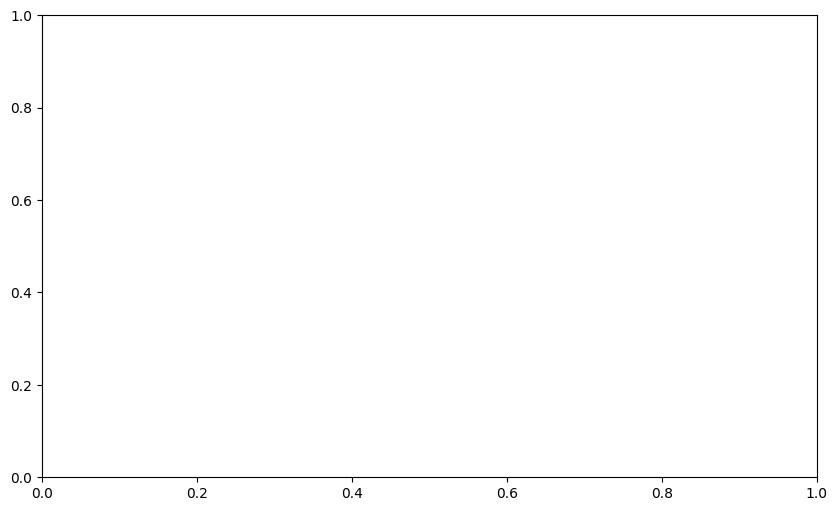

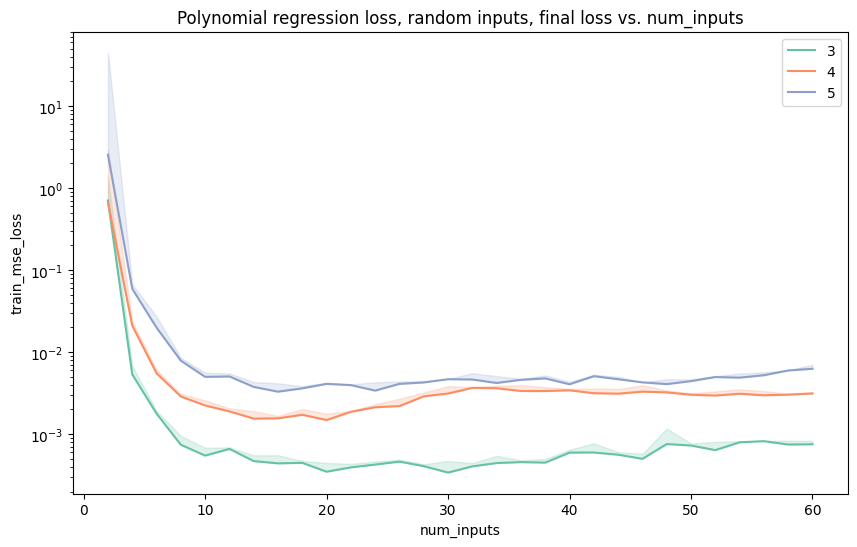

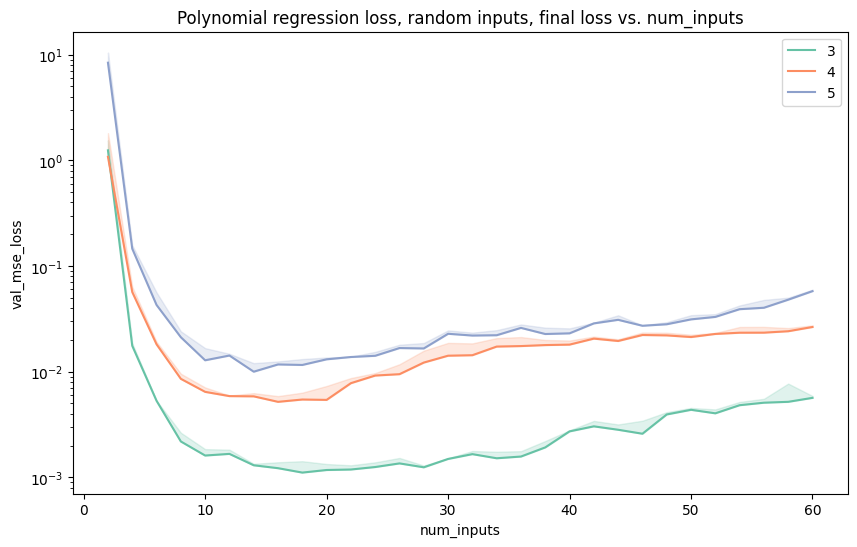

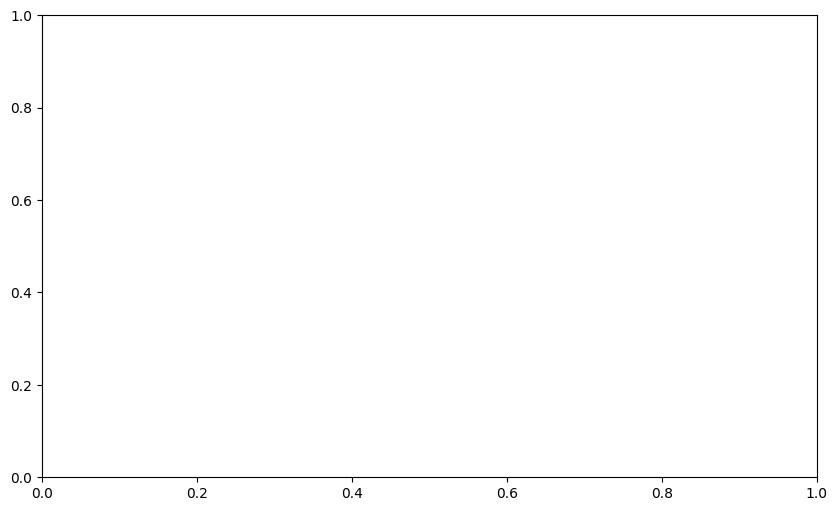

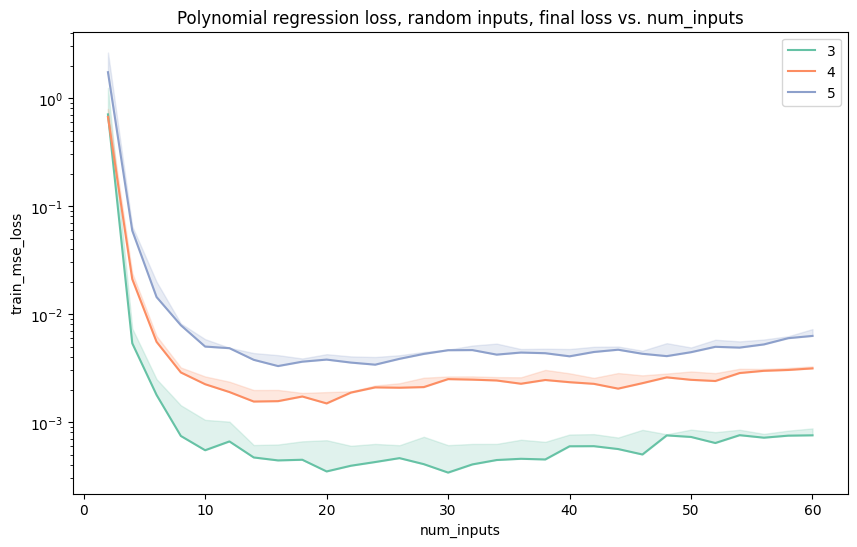

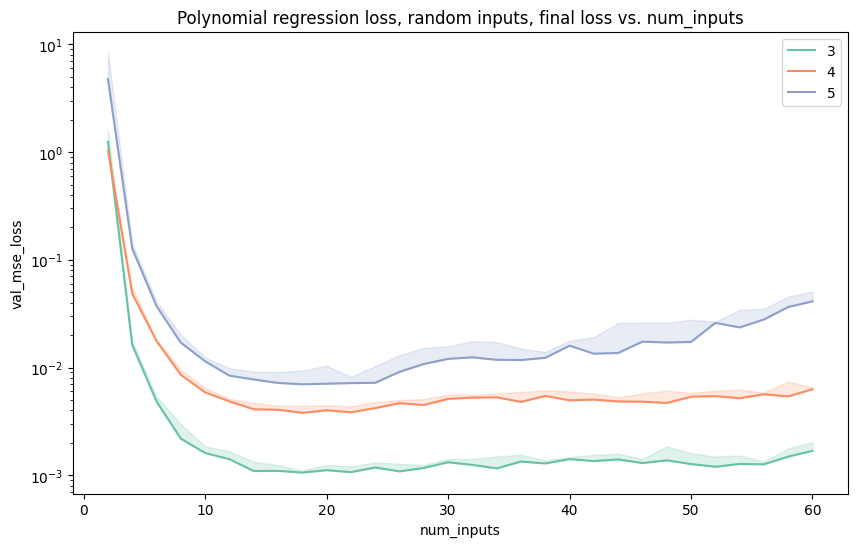

In [10]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               sample_strategy_list = [],
               input_strategy_list=[], 
               l1_list = [],
               order_list = [],
               outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            
            record = utils.load_file_pickle(f)
            #print(record["data_params"]["order"], record["data_params"]["sample_strategy"], record["model_optim_params"]["first_layer_l1_regularize"], record["metrics"]["test_mse_prog"][-1])
            #print(record["metrics"]["test_mse_prog"][-1])
            
        except Exception as e: 
            print(e)
        if record["success"] == False:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        if record["data_params"].get("sample_strategy", None)  not in sample_strategy_list:
            continue 
        if  (order_list is not None) and record["data_params"]["order"] not in order_list:
            continue
        if (l1_list is not None) and record["model_optim_params"]["first_layer_l1_regularize"]  not in l1_list:
            continue 
        #print(f)
        #print(record["model_optim_params"]["first_layer_l1_regularize"])
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["train_mse_loss"].append(record["metrics"]["train_mse_prog"][-1])
        pars["val_mse_loss"].append(record["metrics"]["test_mse_prog"][-1])
        pars["order"].append(record["data_params"]["order"])
        pars["l1"].append(record["model_optim_params"]["first_layer_l1_regularize"])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
#     sns.lineplot(x = "num_inputs", y="train_mse_loss", 
#                   hue="order",
#                  palette = "Set2", data=pars,   estimator='min' )
#     sns.lineplot(x = "num_inputs", y="train_mse_loss",  
#                  hue="order",
#                  palette = "Set2", data=pars[pars["l1"] == 0.0],   estimator='min' )
#     ax.set(yscale="log")
#     plt.legend()
#     plt.ylim(1e-4, 5.5)
#     plt.title(title)
#     plt.show()
    
#     fig, ax = plt.subplots(figsize=(10, 6))
# #     sns.lineplot(x = "num_inputs", y="val_mse_loss", hue="order",
# #                  palette = "Set2", data=pars,   estimator='min' )
#     sns.lineplot(x = "num_inputs", y="val_mse_loss", hue="order",
#                  palette = "Set2", data=pars[pars["l1"] == 0.0],   estimator='min' )
#     ax.set(yscale="log")
#     plt.legend()
#     plt.ylim(1e-4, 5.5)
#     plt.title(title)
#     plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "num_inputs", y="train_mse_loss", 
                  hue="order",
                 palette = "Set2", data=pars,   estimator='min' )
    
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x = "num_inputs", y="val_mse_loss", hue="order",
                 palette = "Set2", data=pars,   estimator='min' )
     
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title(title)
    plt.show()
    
#     sns.lineplot(x = "l1", y="val_mse_loss", hue="order", palette = "Set2", data=pars )
#     ax.set(yscale="log")
#     plt.legend()
#     #plt.ylim(4e-2, 5.5)
#     plt.title(title)
#     plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
# get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 32, 2), 
#            sample_strategy_list=["coefs"],
#            l1_list = None,
#            outdir = "/scratch/gpfs/qanguyen/poly_l1")

# get_record(model_name = "mlp_large", order = "*", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 62, 2), 
#            sample_strategy_list=["roots"],
#            l1_list = [0.0],
#            order_list = [3,4],
#            outdir = "/scratch/gpfs/qanguyen/poly_roots")
workdir = "/scratch/gpfs/qanguyen"
# workdir = "."
get_record(model_name = "mlp_small_repeat", order = "*", input_strategy_list=["repeat"], 
           is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
           num_inputs_list=np.arange(2, 62, 2), 
           sample_strategy_list=["roots"],
           l1_list = [0.0],
           order_list = [3,4,5],
           outdir = f"{workdir}/poly_roots")
get_record(model_name = "mlp_small_repeat", order = "*", input_strategy_list=["repeat"], 
           is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
           num_inputs_list=np.arange(2, 62, 2), 
           sample_strategy_list=["roots"],
           l1_list =  None,
           order_list = [3,4,5],
           outdir = f"{workdir}/poly_roots")
# get_record(model_name = "mlp_small", order = "*", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 32, 2), 
#            sample_strategy_list=["coefs"],
#            l1_list = None,
#            outdir = "./poly_coefs")

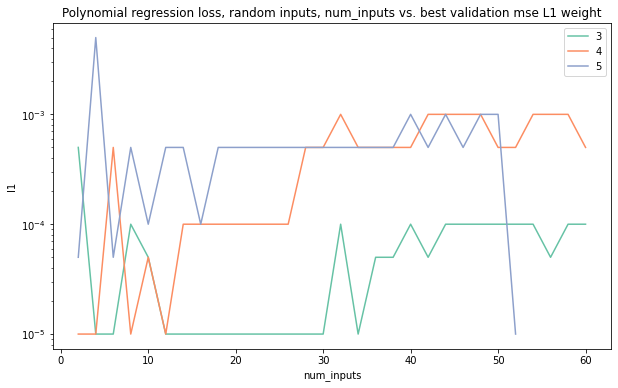

In [25]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               sample_strategy_list = [],
               input_strategy_list=[], 
               l1_list = [],
               outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*")[:]:
        
        try:
            
            record = utils.load_file_pickle(f)
            #print(record["data_params"]["order"], record["data_params"]["sample_strategy"], record["model_optim_params"]["first_layer_l1_regularize"], record["metrics"]["test_mse_prog"][-1])
            #print(record["metrics"]["test_mse_prog"][-1])
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        if record["data_params"].get("sample_strategy", None)  not in sample_strategy_list:
            continue 
        if (l1_list is not None) and record["model_optim_params"]["first_layer_l1_regularize"]  not in l1_list:
            continue 
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["train_mse_loss"].append(record["metrics"]["train_mse_prog"][-1])
        pars["val_mse_loss"].append(record["metrics"]["test_mse_prog"][-1])
        pars["order"].append(record["data_params"]["order"])
        pars["l1"].append(record["model_optim_params"]["first_layer_l1_regularize"])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    #display(pars)
    pars = pars.sort_values(['val_mse_loss'],ascending=True).groupby(["order","num_inputs"]).head(1)
    sns.lineplot(x = "num_inputs", y="l1", 
                  hue="order",
                 palette = "Set2", data=pars  )
#     sns.lineplot(x = "num_inputs", y="l1",  
#                  hue="order",
#                  palette = "Set2", data=pars[pars["l1"] == 0.0],   estimator='min' )
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title(title)
    plt.show()
    
#     fig, ax = plt.subplots(figsize=(10, 6))
#     sns.lineplot(x = "num_inputs", y="l1", hue="order",
#                  palette = "Set2", data=pars,   estimator='min' )
#     sns.lineplot(x = "num_inputs", y="l1", hue="order",
#                  palette = "Set2", data=pars[pars["l1"] == 0.0],   estimator='min' )
#     ax.set(yscale="log")
#     plt.legend()
#     plt.ylim(1e-4, 5.5)
#     plt.title(title)
#     plt.show()
    
#     sns.lineplot(x = "l1", y="val_mse_loss", hue="order", palette = "Set2", data=pars )
#     ax.set(yscale="log")
#     plt.legend()
#     #plt.ylim(4e-2, 5.5)
#     plt.title(title)
#     plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
# get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 32, 2), 
#            sample_strategy_list=["coefs"],
#            l1_list = None,
#            outdir = "/scratch/gpfs/qanguyen/poly_l1")

get_record(model_name = "mlp_small", order = "*", input_strategy_list=["random"], 
           is_online=False, title = f"Polynomial regression loss, random inputs, num_inputs vs. best validation mse L1 weight", 
           num_inputs_list=np.arange(2, 62, 2), 
           sample_strategy_list=["roots"],
           l1_list = None,
           outdir = "./poly_roots")

In [11]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               l1list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        if record["model_optim_params"]["first_layer_l1_regularize"] not in l1list:
            continue 
        print(f)
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["train_mse_loss"].append(record["metrics"]["train_mse_prog"][-1])
        pars["val_mse_loss"].append(record["metrics"]["test_mse_prog"][-1])
        pars["order"].append(record["data_params"]["order"])
        pars["l1"].append(record["model_optim_params"]["first_layer_l1_regularize"])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        #print(f, "noise", record["data_params"]["noise"])
        fig, ax = plt.subplots(figsize=(10, 6))
        img = record["model"].fc1.weight.cpu().detach().numpy()[:20]
        print(np.min(img),np.max(img))
        #print(img[:5])
        plt.imshow(img)
        plt.show()
#     pars = pd.DataFrame.from_dict(pars) 
#     sns.lineplot(x = "l1", y="train_mse_loss", hue=pars[["order"]].apply(tuple, axis=1),  palette = "Set2", data=pars )
#     ax.set(yscale="log")
#     plt.legend()
#     #plt.ylim(4e-2, 5.5)
#     plt.title(title)
#     plt.show()
    
#     fig, ax = plt.subplots(figsize=(10, 6))
#     sns.lineplot(x = "l1", y="train_loss", hue=pars[["order"]].apply(tuple, axis=1),  palette = "Set2", data=pars )
#     ax.set(yscale="log")
#     plt.legend()
#     #plt.ylim(4e-2, 5.5)
#     plt.title(title)
#     plt.show()
    
#     sns.lineplot(x = "l1", y="val_mse_loss", hue="order", palette = "Set2", data=pars )
#     ax.set(yscale="log")
#     plt.legend()
#     #plt.ylim(4e-2, 5.5)
#     plt.title(title)
#     plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
# for num_inputs in np.arange(2, 32, 2):
get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
           is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs: {num_inputs}", 
           num_inputs_list= [4], 
           l1list = [0.0],
           outdir = "./poly_l1")

NameError: name 'num_inputs' is not defined

In [ ]:
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        img = record["model"].fc1.weight.cpu().detach().numpy()[:20]
        #print(img[:5])
        plt.imshow(img)
        plt.show()
    print(pars)
# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, pre-trained with different num_inputs, order=3", 
           num_inputs_list=[30], 
           outdir = "./poly_l1")

In [16]:
import polynomial
importlib.reload(polynomial)
d = polynomial.PolynomialData(num_examples = 15, num_inputs=200, order=10, random_coefs=True, input_strategy="random", is_online=False, noise=1.0e-1, output_strategy="evaluate_at_0", sample_strategy="roots")

0.21745750308036804
-0.3087726831436157
-0.04874487221240997
-0.320981502532959
-0.751284122467041
-0.755465030670166
-0.5410385727882385
-0.498851478099823
-0.22958678007125854
0.7995984554290771
-0.9391327500343323
0.07341300696134567
0.9624411463737488
-0.34841153025627136
-0.14078107476234436


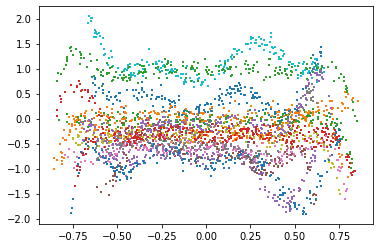

In [18]:
for num_e in range(len(d)):
    num_inp = 200
    plt.scatter(d[num_e][0][:num_inp], d[num_e][0][num_inp:], marker="+", s=2)
    # plt.ylim(-1.1,1.1)
    print(d[num_e][1])

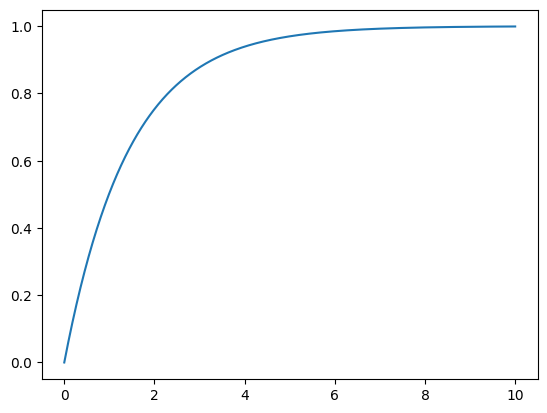

In [52]:
order=10
e = torch.distributions.exponential.Exponential(rate=7.0/order)
p = [(e.cdf(torch.tensor(i))) for i in np.linspace(0, order, 1000)]
plt.plot(np.linspace(0, 10, 1000), p )

In [77]:
n = torch.ceil(e.rsample([d.order]))
sums = torch.cumsum(n, dim=0)
sums = sums[sums <= d.order]
n = n[:len()]

In [78]:
n

tensor([1., 3., 2., 2., 1., 1.])

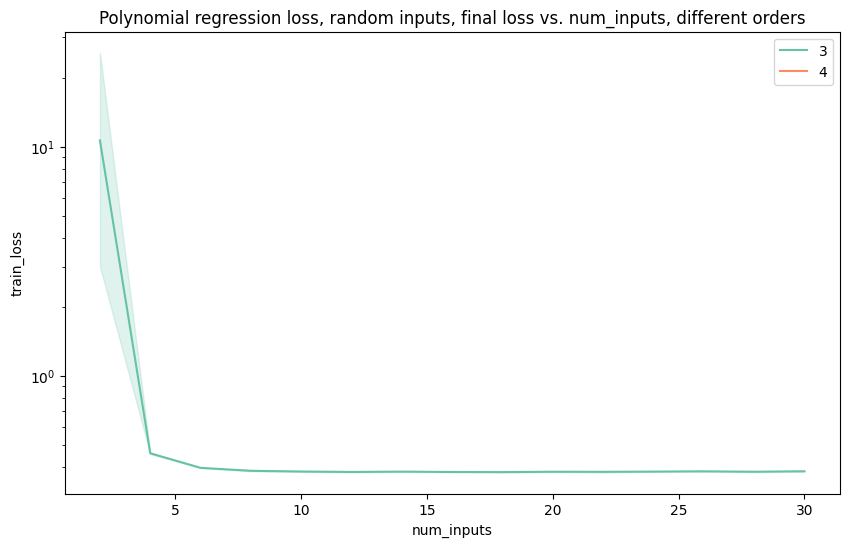

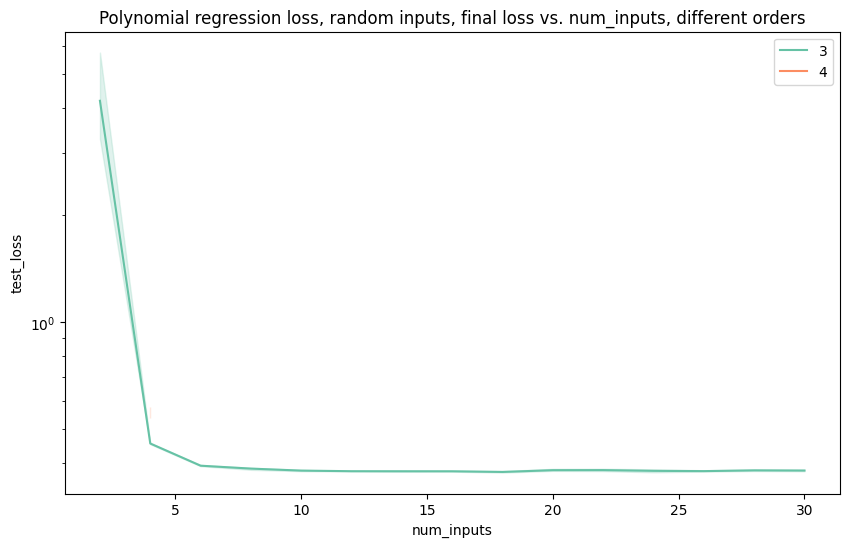

In [328]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].append(record["metrics"]["train_mse_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_mse_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        pars["order"].append(record["data_params"]["order"])
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="train_loss", hue="order",  palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
#     plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="test_loss", hue="order", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
#     plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, different orders", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir = "/scratch/gpfs/qanguyen/poly_roots")


In [ ]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].append(record["metrics"]["train_mse_prog"] )
        pars["test_loss"].append(record["metrics"]["test_mse_prog"])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        pars["order"].append(record["data_params"]["order"])
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="train_loss", hue="order",  palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
#     plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="test_loss", hue="order", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
#     plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, different orders", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir = "/scratch/gpfs/qanguyen/poly_roots")


/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


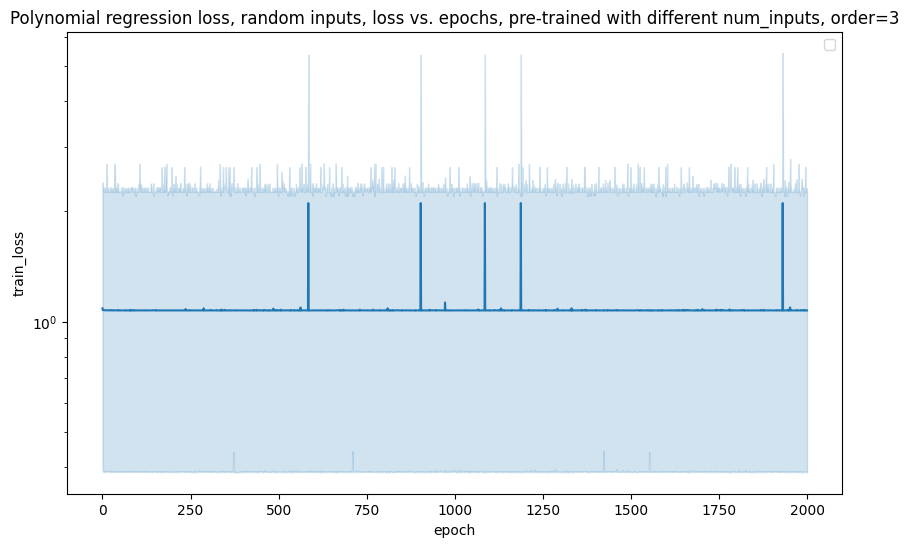

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


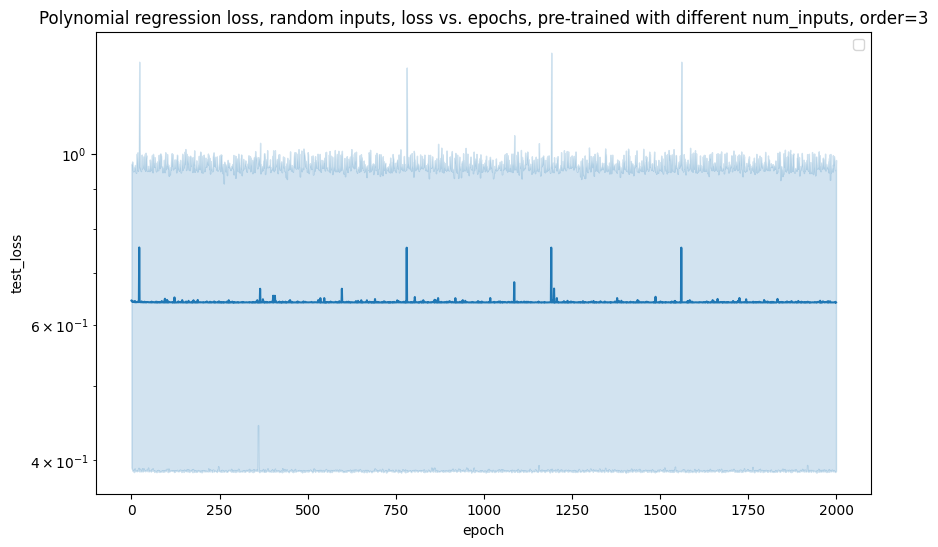

In [349]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
         
        #pars["num_inputs"].append(record["data_params"]["num_inputs"])
        # pars["num_inputs_kept"].append(record["train_params"]["num_inputs_kept"])
        
        pars["train_loss"].extend(record["metrics"]["train_mse_prog"])
        pars["test_loss"].extend(record["metrics"]["test_mse_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["order"].append(record["data_params"]["order"])
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue="order",  palette = "Set2", data=pars  )
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss",  hue="order",  palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, loss vs. epochs, pre-trained with different num_inputs, order=3", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir =  "/scratch/gpfs/qanguyen/poly_roots")

## Attention

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662484172.58822.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662449731.247456.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662475501.277991.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662449760.594867.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662463919.866433.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662449730.946023.

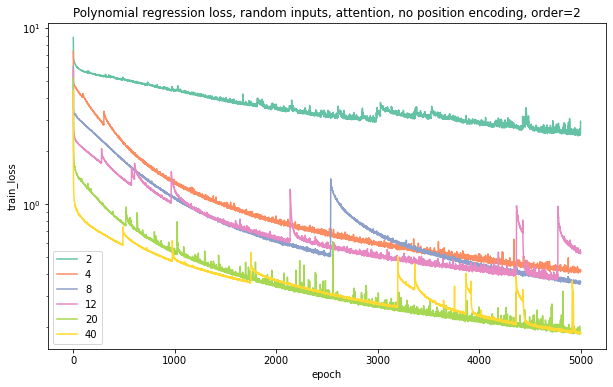

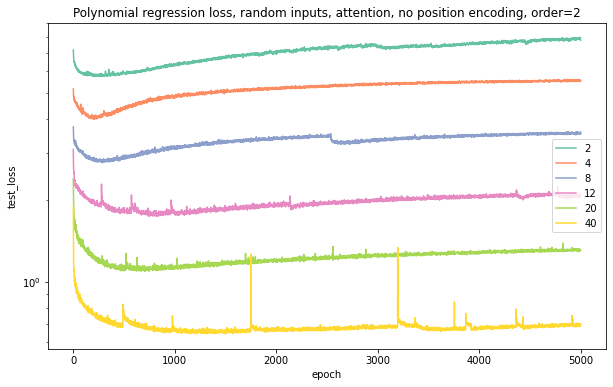

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662463467.368335.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662483453.933914.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662478645.662084.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662449700.631759.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662466470.337386.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662475811.07033

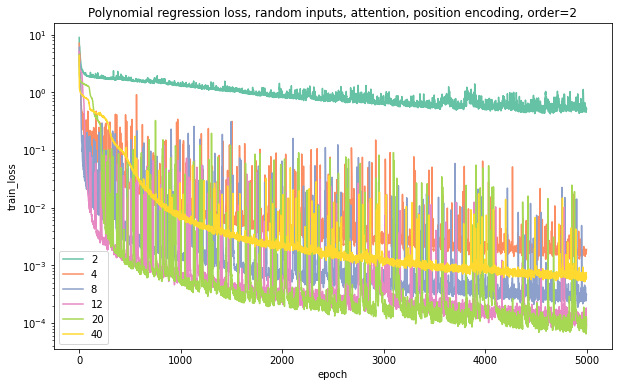

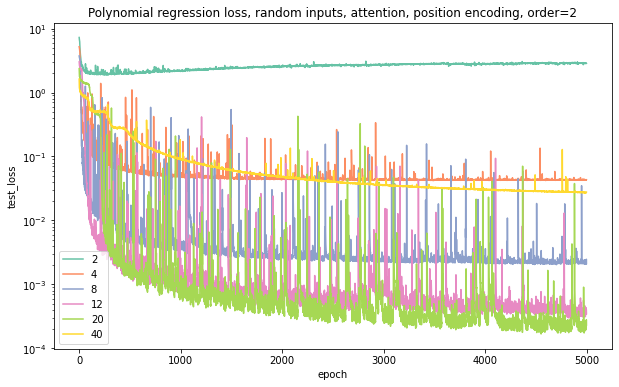

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662470398.204635.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662468451.198952.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662453450.85505.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439086.970412.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439117.219949.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439086.941504.

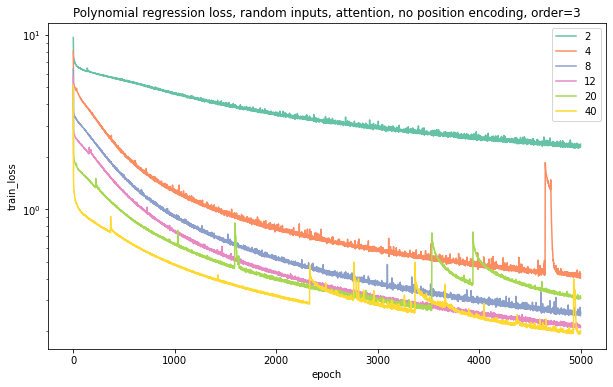

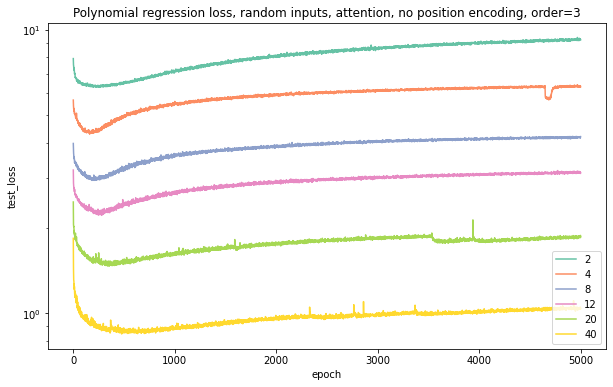

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662455856.919402.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662469898.597653.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662491107.012901.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439147.212894.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439177.82179.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662454326.0969

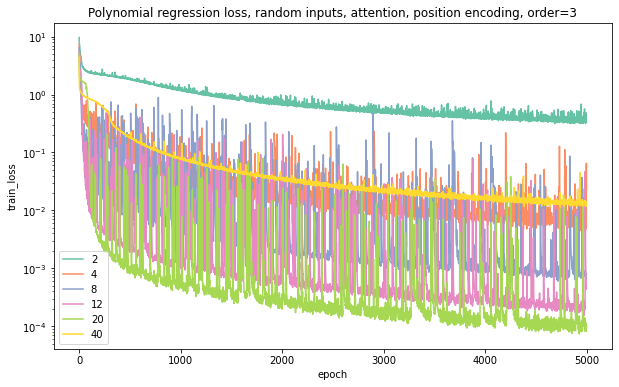

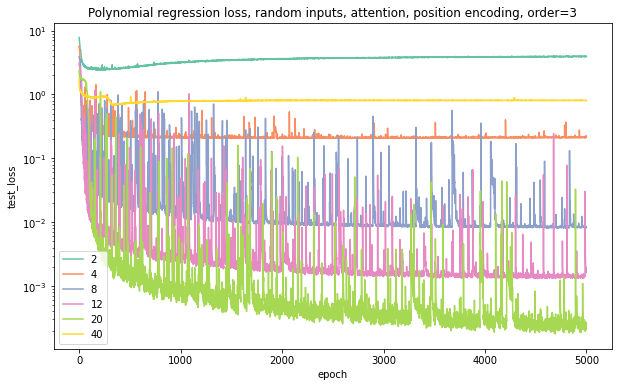

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512242.440004.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662463446.362753.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662477598.74391.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662498051.987424.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662483164.535306.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662497825.547672.pk

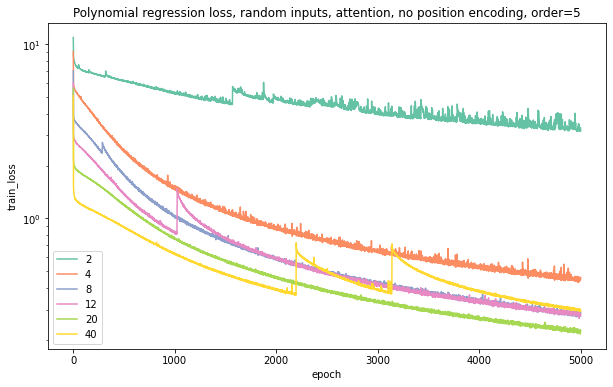

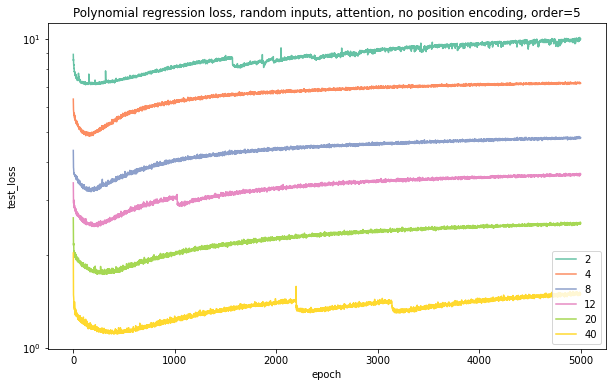

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662543792.610659.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662528542.084614.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662564597.525783.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512211.94296.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512242.28512.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512272.543328.p

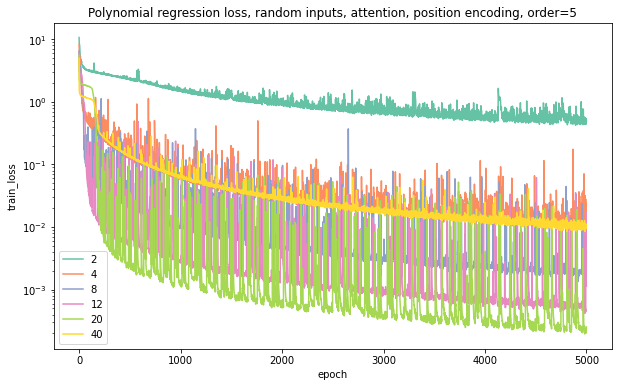

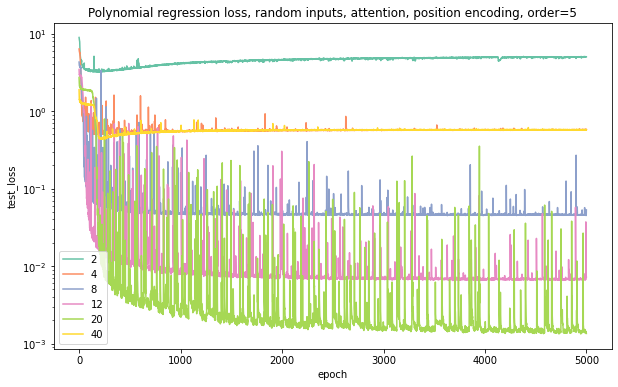

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662503755.225345.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662487127.712982.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662489646.362909.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662507438.083168.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662499703.052722.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662518344.8

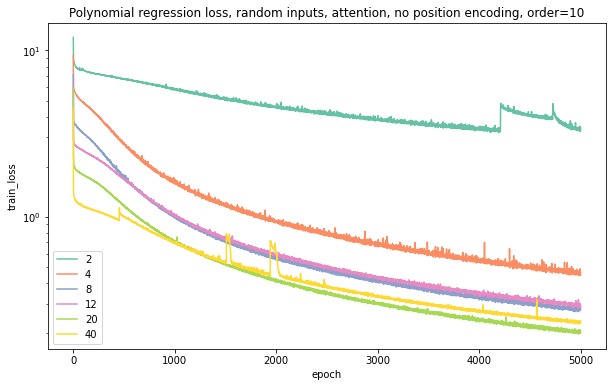

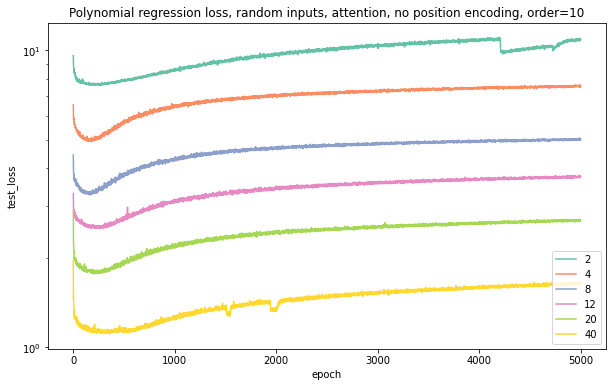

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662528040.666063.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512272.501133.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662528724.944275.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662545093.478957.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512303.105787.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662526742.2

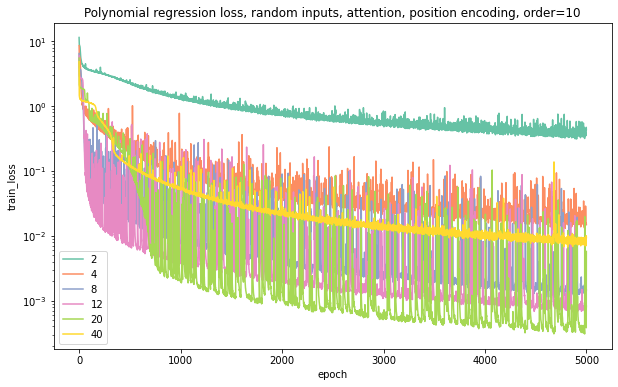

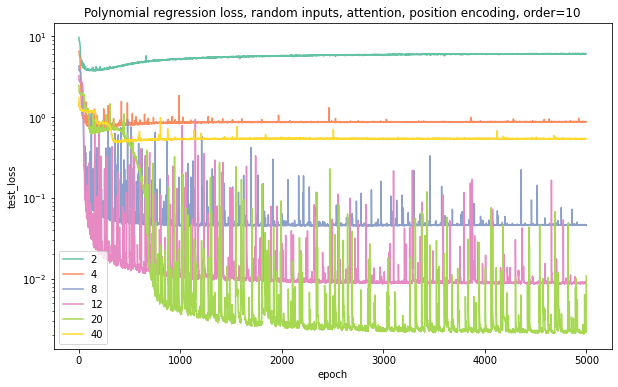

In [19]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        model = record["model"]
        if (model.pe_weight not in pe_weight_list):
            continue
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"], "pe_weight", model.pe_weight)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings



get_record(model_name = "attention_small", order = 2, input_strategy_list=["random"], 
           pe_weight_list = [0.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 2, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           pe_weight_list = [0.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=3", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=3", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 5, input_strategy_list=["random"], 
           pe_weight_list = [0.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 5, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 10, input_strategy_list=["random"], 
           pe_weight_list = [0.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 10, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662605367.98195.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662602671.078724.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662562098.92317.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662577338.536878.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662563715.982831.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662570323.73

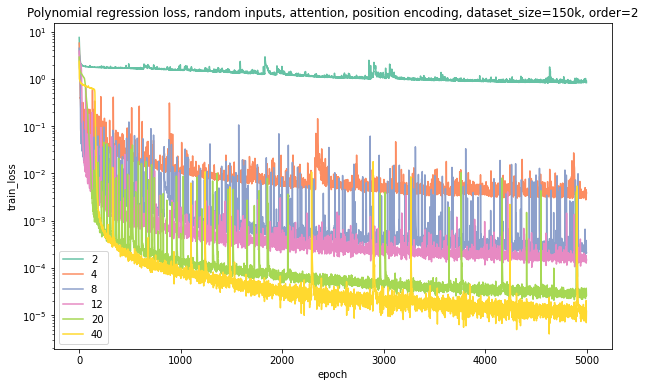

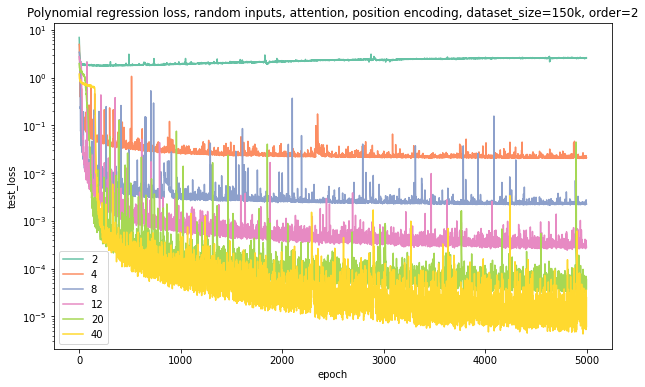

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662559203.602351.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662601434.326832.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662557631.023955.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662559595.507944.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662556667.186658.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662598624.8

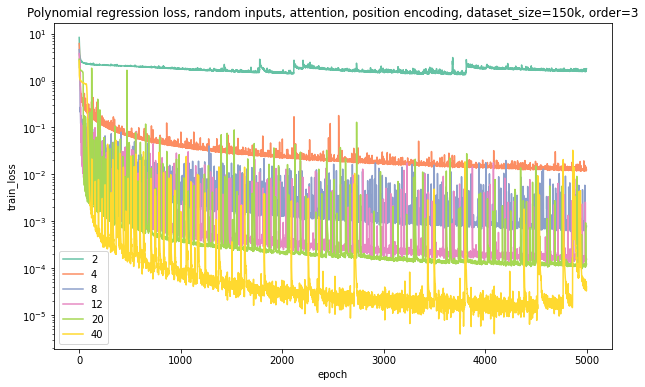

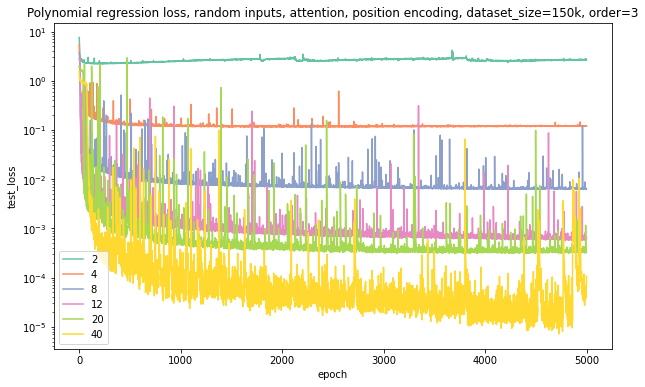

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662536972.490943.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662534446.883908.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662553845.315084.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662536038.41177.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662576170.778538.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662541335.9

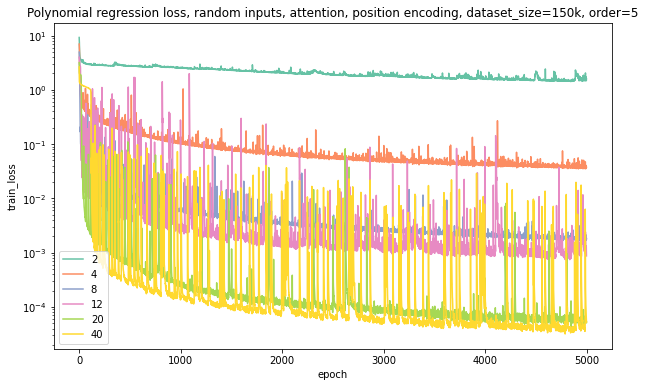

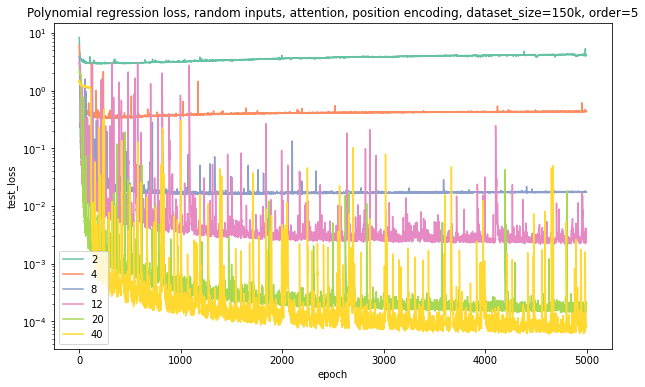

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662517180.883856.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662529505.069194.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662527238.313941.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662558495.785183.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662526938.197822.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_166251

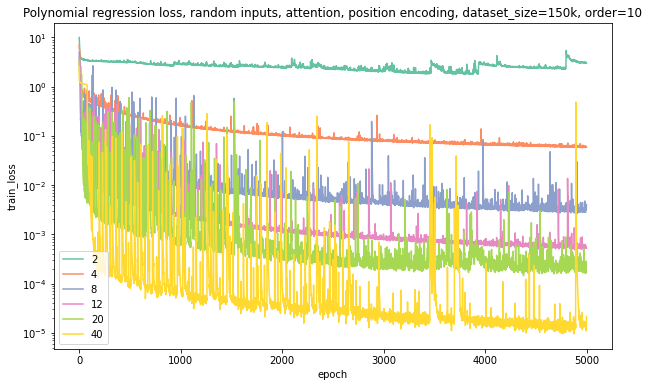

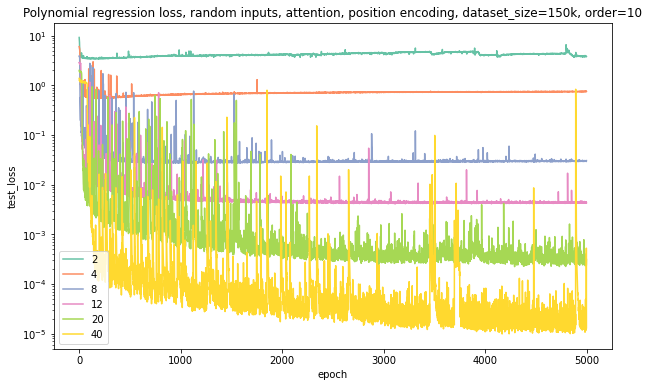

In [22]:
# get_record(model_name = "attention_small", order = 2, input_strategy_list=["random"], 
#            pe_weight_list = [0.0],
#            num_examples_list = [150000],
#            is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=2", 
#            num_inputs_list=[2, 4,8,12,20, 40, 60], 
#            outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 2, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, dataset_size=150k, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
# get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
#            pe_weight_list = [0.0],
#            num_examples_list = [150000],
#            is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=3", 
#            num_inputs_list=[2, 4,8,12,20, 40, 60], 
#            outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, dataset_size=150k, order=3", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
# get_record(model_name = "attention_small", order = 5, input_strategy_list=["random"], 
#            pe_weight_list = [0.0],
#            num_examples_list = [150000],
#            is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=5", 
#            num_inputs_list=[2, 4,8,12,20, 40, 60], 
#            outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 5, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, dataset_size=150k, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 10, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, dataset_size=150k, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707330.470947.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662713732.381864.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662714584.265482.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700850.824999.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700822.60721.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707436.160721.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_4_numexamples_50000_is_online

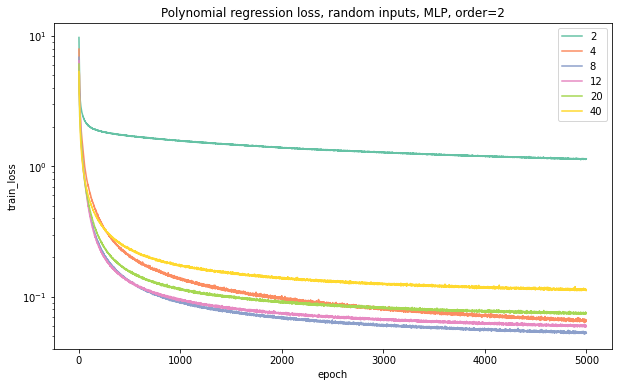

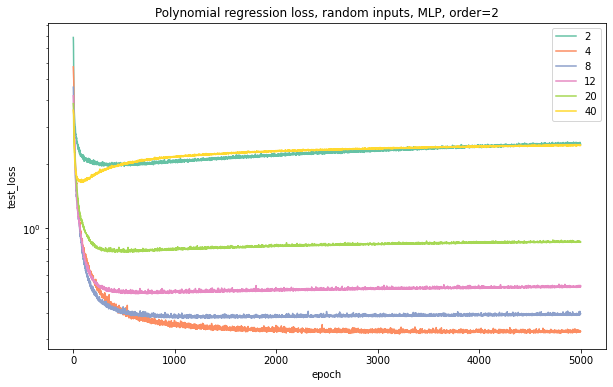

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707476.028768.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662714514.15584.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700911.822541.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700850.653939.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707652.768647.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700955.35254.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_4_numexamples_50000_is_online_

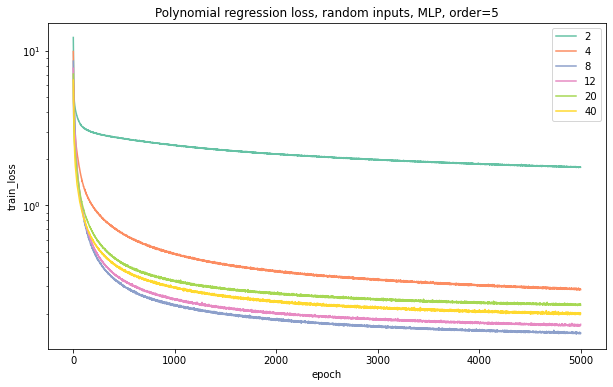

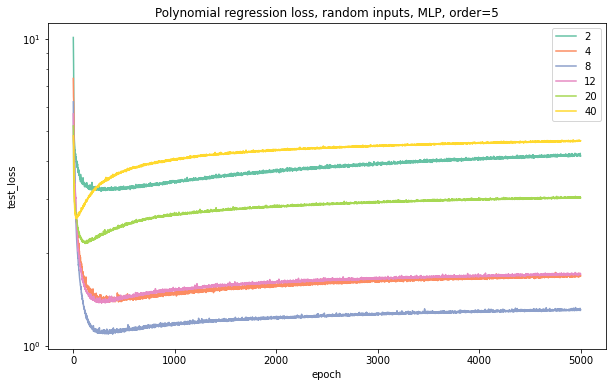

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707529.400394.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707979.578001.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662714450.92583.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707555.876422.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700971.05094.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662714718.371119.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_2_numexamples_50000_is_on

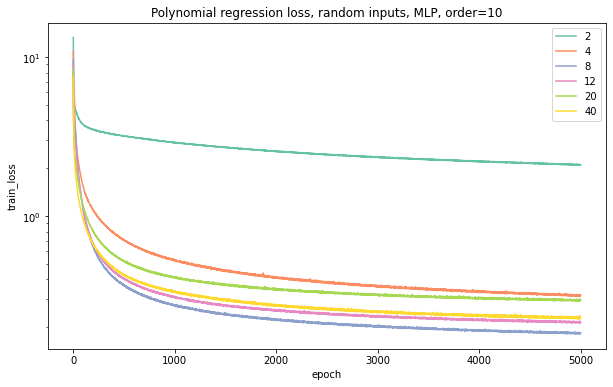

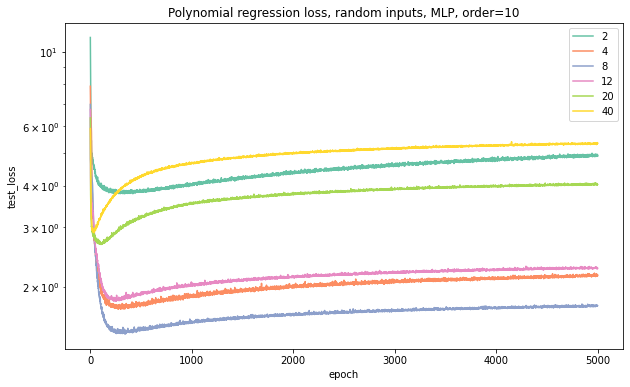

In [31]:
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
get_record(model_name = "mlp_small", order = 2, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_small", order = 5, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_small", order = 10, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662739520.575269.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662721410.67581.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662721531.121621.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662721410.67911.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662738773.956107.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662721590.914685.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_12_numexamples_150000_is_o

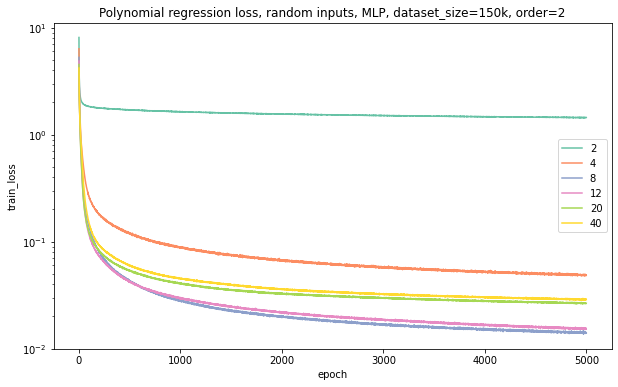

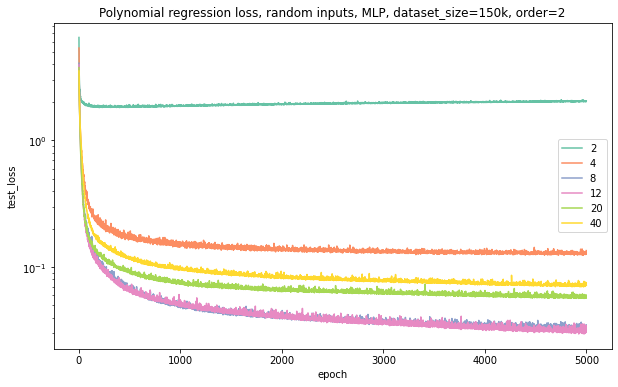

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662718809.954504.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662737760.525819.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662737316.2151.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662738201.094543.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662720690.480012.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662737458.976362.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_40_numexamples_150000_is_on

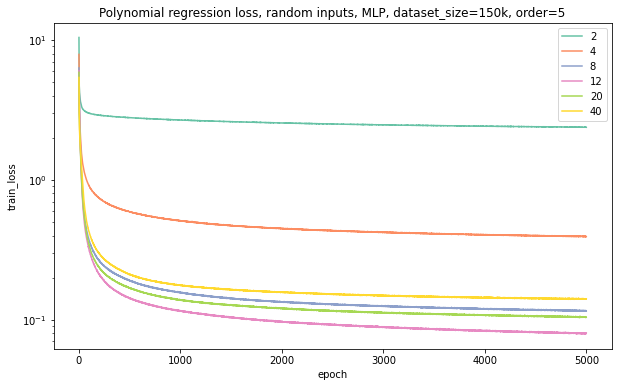

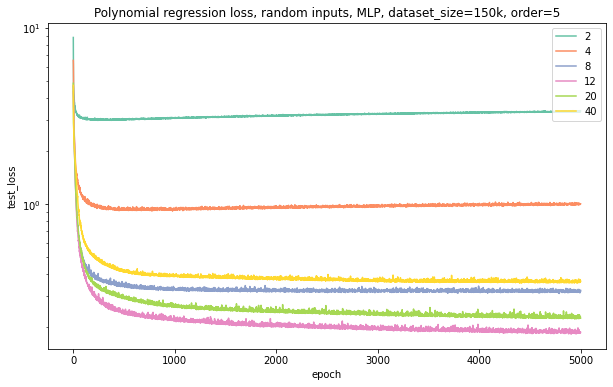

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662701030.350261.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662718768.33673.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662701030.843413.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662739721.9851.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662739025.86817.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662701000.470395.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_2_numexamples_150000

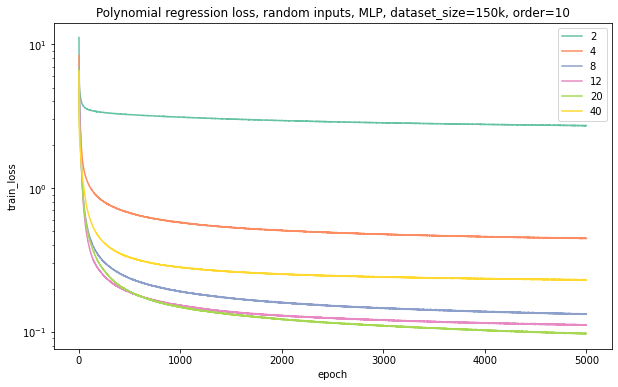

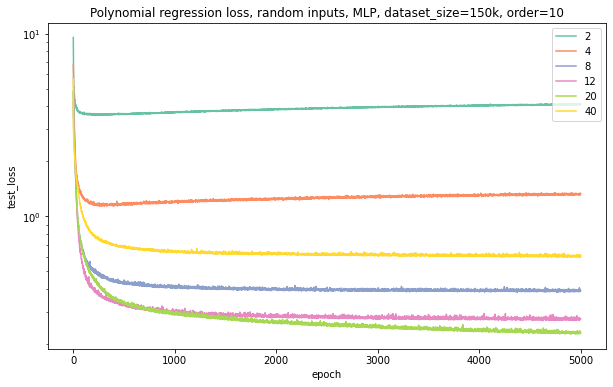

In [32]:
get_record(model_name = "mlp_small", order = 2, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_small", order = 5, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_small", order = 10, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662736605.714957.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662737154.544075.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662729708.033183.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662737286.858098.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662737474.225041.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662721862.480645.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_2_numexamples_50000_is_online

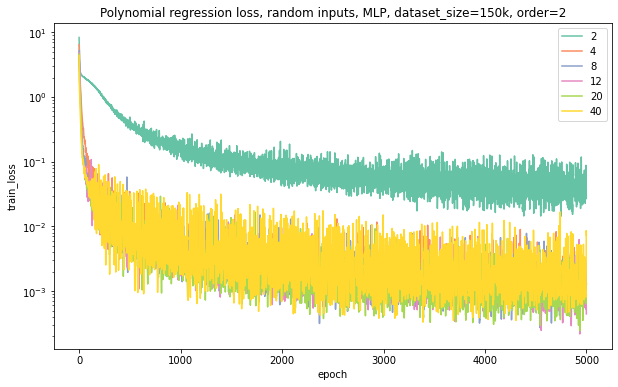

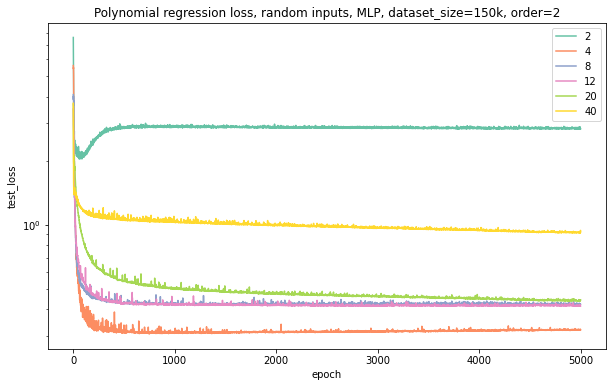

/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662751413.085291.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662722680.347041.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662744950.197873.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662730383.776404.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662744196.531927.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662744919.962048.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_40_numexamples_50000_is_online_F

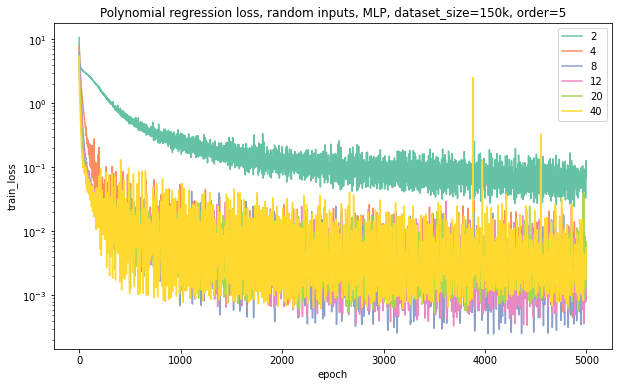

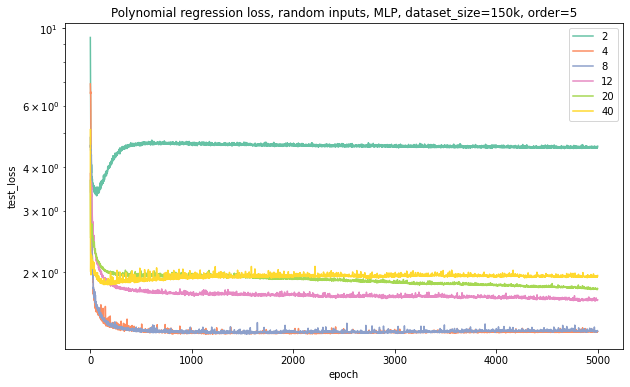

/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_10_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662746500.636998.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662745310.888599.pkl noise 0.0


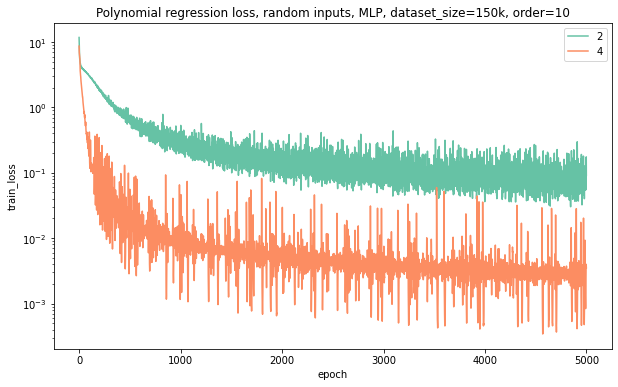

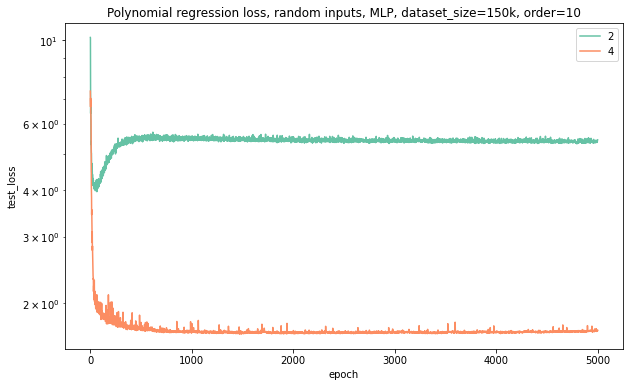

In [33]:
get_record(model_name = "mlp_large", order = 2, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_large", order = 5, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_large", order = 10, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

ValueError: Could not interpret value `epoch` for parameter `x`

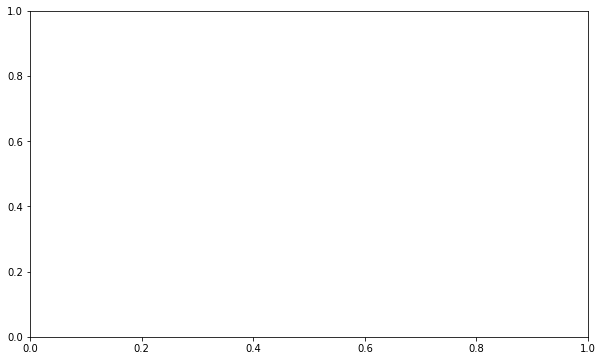

In [34]:
get_record(model_name = "mlp_large", order = 2, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_large", order = 5, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_large", order = 10, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

In [10]:
import utils
dat = utils.load_file_pickle("./random_sorted_data.pkl")

In [11]:
xs = torch.stack([x for x in list(zip(*dat))][0])

In [34]:
hs = []
for inds in xs.T[:20]:
    hs.append(torch.histogram(inds,bins=torch.linspace(-1,1,51), density=True))
hist = torch.stack([h[0] for h in hs])
hs = []
for inds in xs.T[20:]:
    hs.append(torch.histogram(inds,bins=torch.linspace(-20,20,51), density=True))
yhist = torch.stack([h[0] for h in hs])

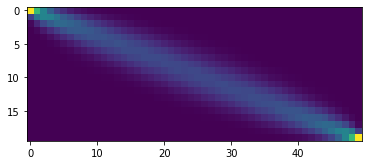

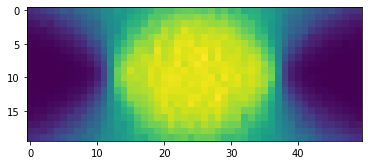

In [41]:
plt.imshow(hist)
# plt.xticks(ticks=torch.arange(0,51,9),labels=np.linspace(-1,1,6))
plt.show()
plt.imshow(yhist)
plt.show()

/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663537490.340852.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663537492.89641.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663551443.361433.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663550424.554344.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663551105.715962.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663543902.103503.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_a

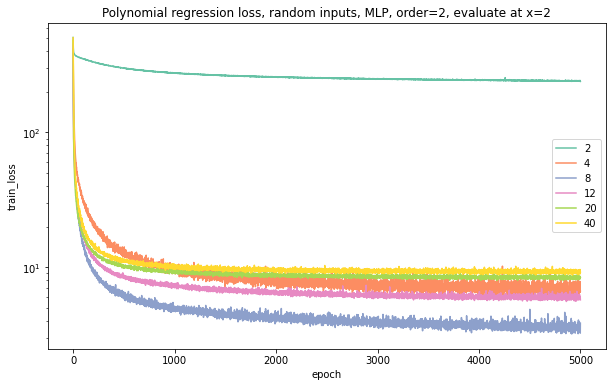

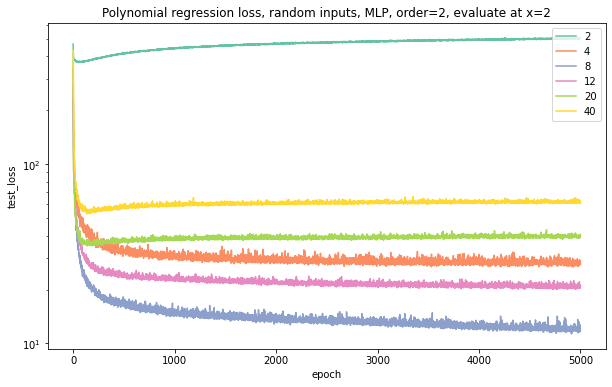

/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663537564.608078.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663543880.300945.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663551272.75634.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663543688.305074.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663537577.791083.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663550414.708868.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_a

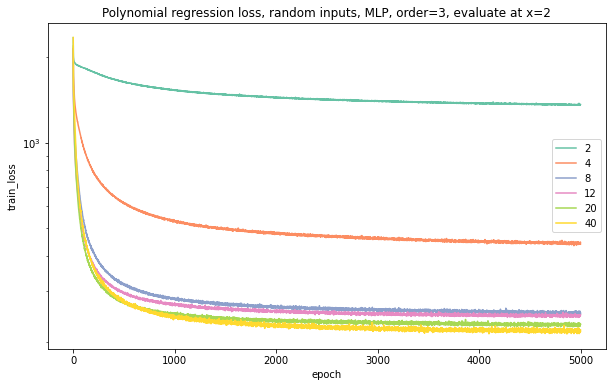

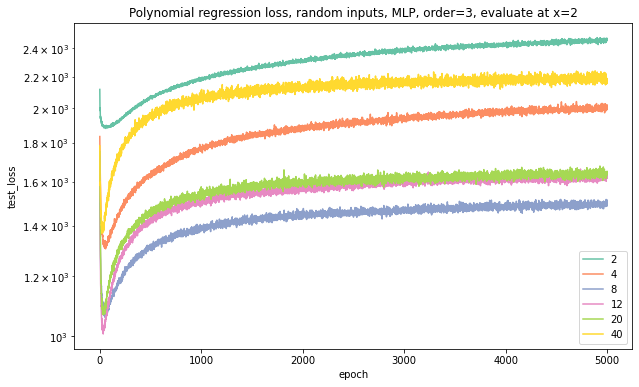

/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537684.477455.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663555669.458592.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537684.734247.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663554919.518256.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537687.472856.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663555473.880653.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_eva

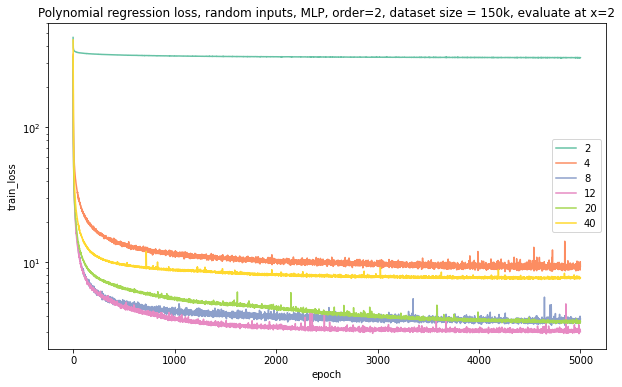

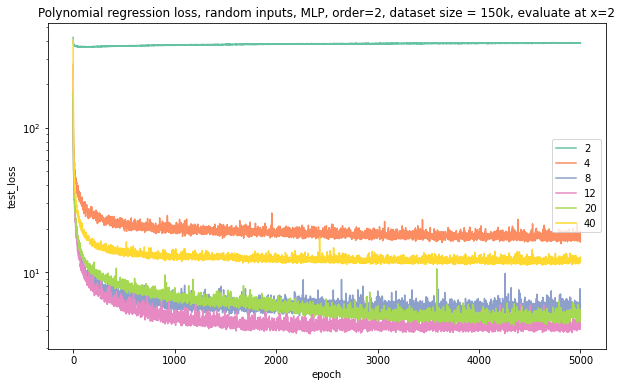

/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537578.935118.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663593973.776442.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537592.508893.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537592.52801.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663573375.693704.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663574945.216018.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_eva

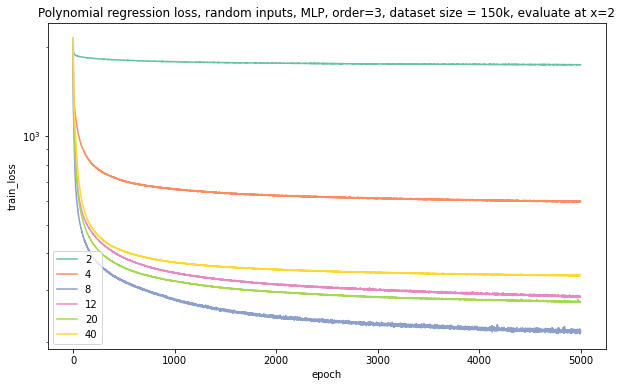

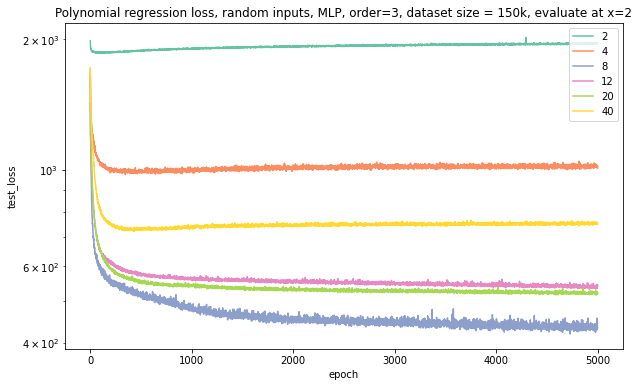

In [45]:
import warnings
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
get_record(model_name = "mlp_small", order = 2, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=2, evaluate at x=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_evaluate_at_2")
get_record(model_name = "mlp_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=3, evaluate at x=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_evaluate_at_2")
get_record(model_name = "mlp_small", order = 2, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=2, dataset size = 150k, evaluate at x=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_evaluate_at_2")
get_record(model_name = "mlp_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=3, dataset size = 150k, evaluate at x=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_evaluate_at_2")



/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557601.851563.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557450.201166.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557360.492494.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557631.224945.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557691.268491.pkl noise 0.0


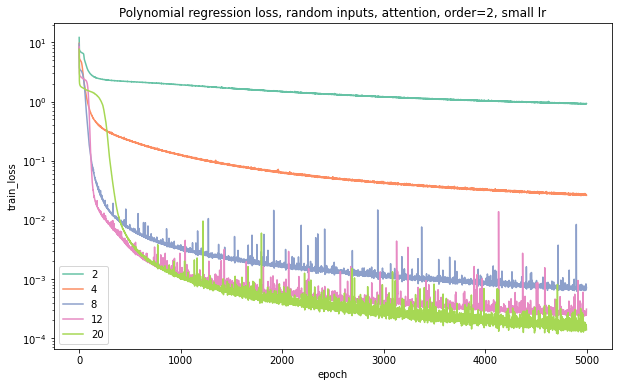

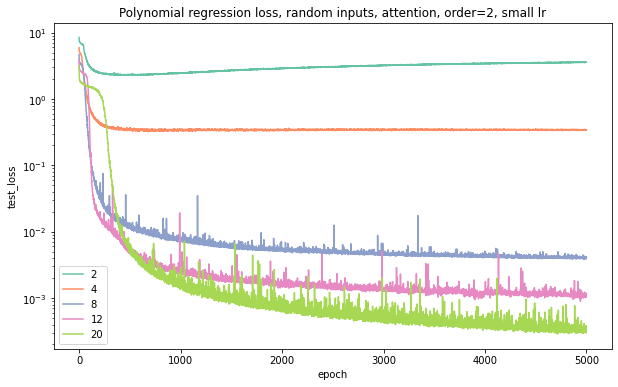

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557601.851563.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557450.201166.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557360.492494.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557631.224945.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557691.268491.pkl noise 0.0


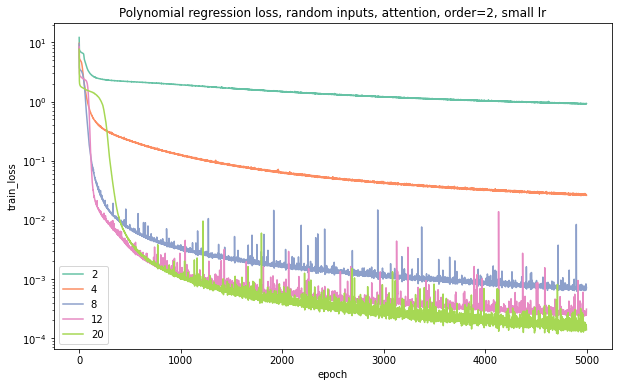

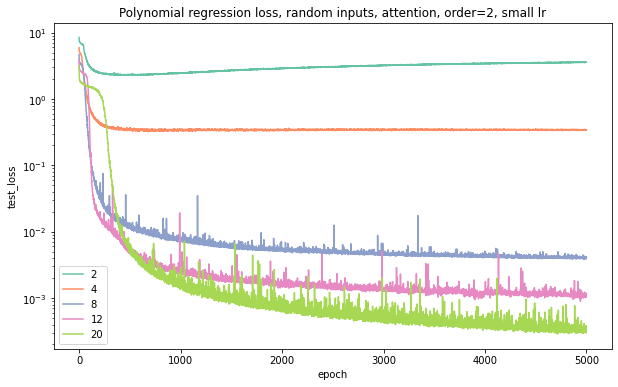

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557601.851563.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557450.201166.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557360.492494.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557631.224945.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557691.268491.pkl noise 0.0


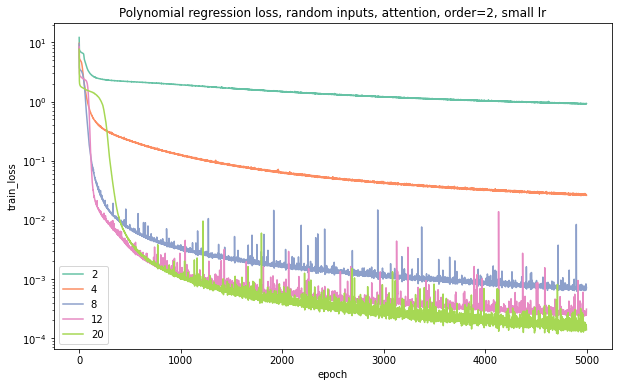

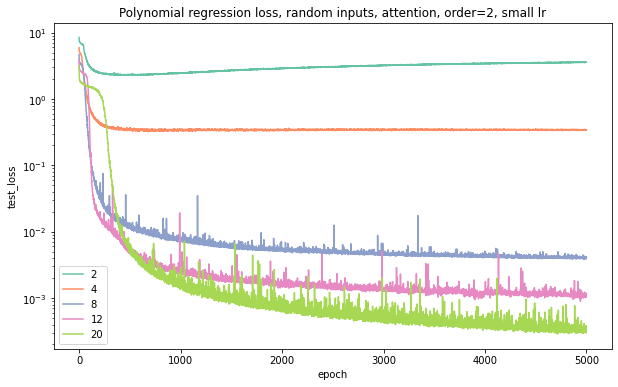

In [51]:
import warnings
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [], lr_list=[],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        if record["model_optim_params"]["optimizer"].param_groups[0]['lr'] not in lr_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")



ValueError: Could not interpret value `epoch` for parameter `x`

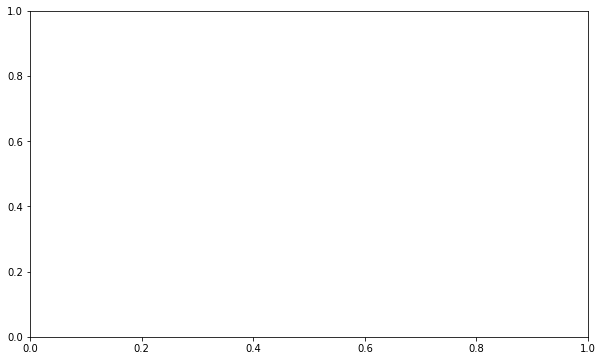

In [53]:
import warnings
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [], lr_list=[],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["is_online"] not in is_online:
            continue
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        if record["model_optim_params"]["optimizer"].param_groups[0]['lr'] not in lr_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=[True], title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4,0.5e-3],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=[True], title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4,0.5e-3],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=[True], title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4,0.5e-3],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")



## Noise

In [25]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, 
               order_list = [], noise_list = [],
               outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*_is_online_{is_online}_*"):
        print(f)
        
        record = utils.load_file_pickle(f)
        if record["data_params"]["num_inputs"] not in order_list:
             continue
        if record["data_params"]["noise"] not in noise_list:
            continue
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))

    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings


/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_80_numexamples_50000_is_online_False_rep_1660448081.383974.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660480137.354691.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_20_numexamples_50000_is_online_False_rep_1660461795.745184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660473487.961765.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1660454205.619352.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660493174.530665.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_60_numexamples_50000_is_online_False_rep_1660505233.522593.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660486799.028931.pkl
/sc

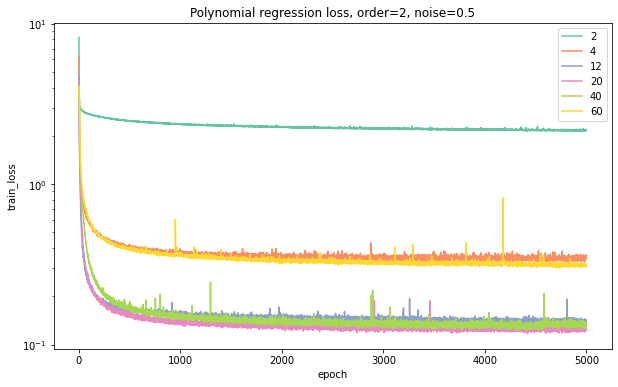

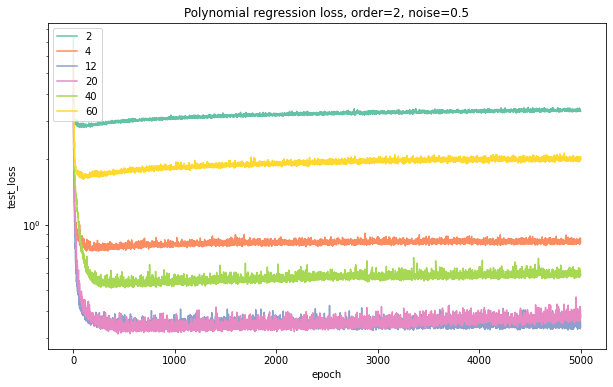

/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_80_numexamples_50000_is_online_False_rep_1660448081.383974.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660480137.354691.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_20_numexamples_50000_is_online_False_rep_1660461795.745184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660473487.961765.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1660454205.619352.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660493174.530665.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_60_numexamples_50000_is_online_False_rep_1660505233.522593.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660486799.028931.pkl
/sc

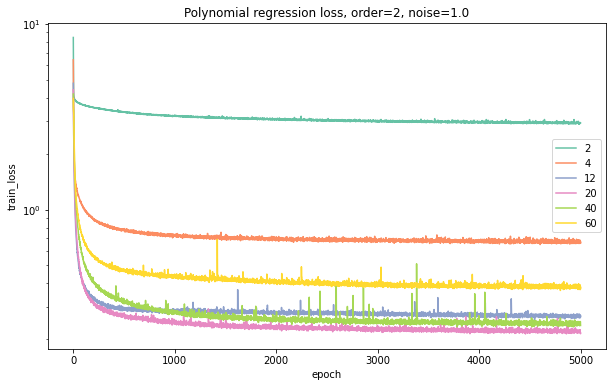

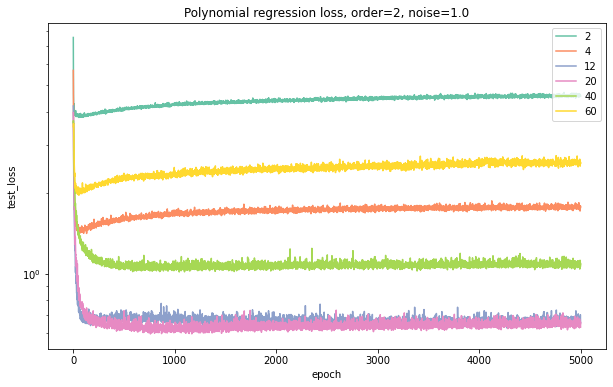

/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1660587508.15507.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587616.633156.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1660587508.236121.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587621.874653.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587621.883807.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587677.557184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587677.677067.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587628.913662.pkl
/scra

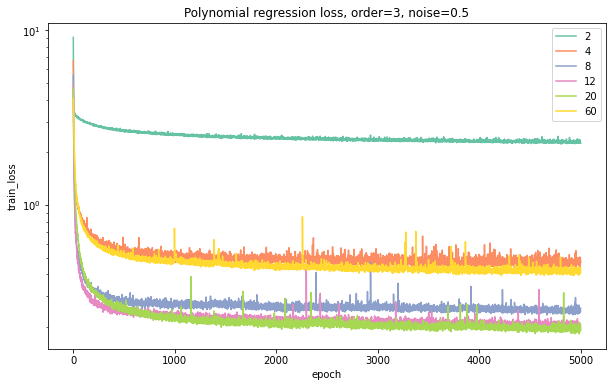

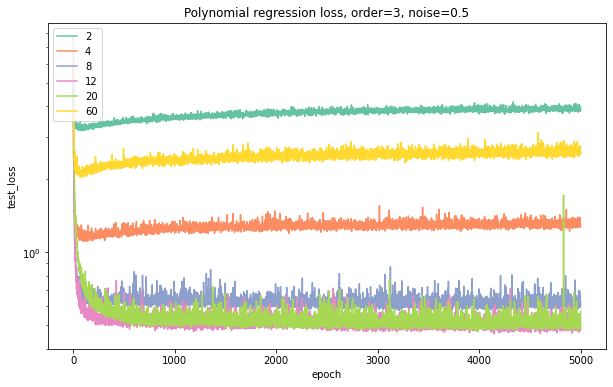

/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1660587508.15507.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587616.633156.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1660587508.236121.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587621.874653.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587621.883807.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587677.557184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587677.677067.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587628.913662.pkl
/scra

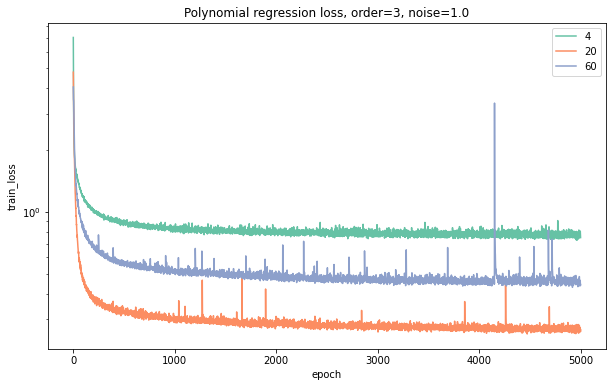

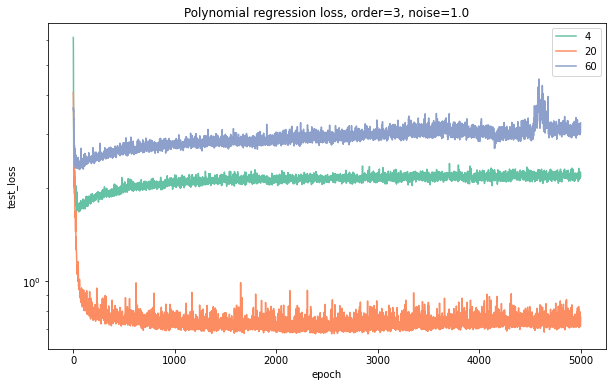

In [29]:
get_record(model_name = "mlp_small", order = 2, is_online=False, title = "Polynomial regression loss, order=2, noise=0.5", order_list=[2, 4,8,12,20, 40, 60], noise_list = [0.5], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
get_record(model_name = "mlp_small", order = 2, is_online=False, title = "Polynomial regression loss, order=2, noise=1.0", order_list=[2, 4,8,12,20, 40, 60], noise_list = [1.0], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
get_record(model_name = "mlp_small", order = 3, is_online=False, title = "Polynomial regression loss, order=3, noise=0.5", order_list=[2, 4,8,12,20, 40, 60], noise_list = [0.5], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
get_record(model_name = "mlp_small", order = 3, is_online=False, title = "Polynomial regression loss, order=3, noise=1.0", order_list=[2, 4,8,12,20, 40, 60], noise_list = [1.0], outdir = "/scratch/gpfs/qanguyen/poly_noise/")


# Imagenet

In [3]:
import imagenet
importlib.reload(imagenet)
 
#d = imagenet_devel.RescaleImagenet(root = "/scratch/gpfs/DATASETS/imagenet/ilsvrc_2012_classification_localization",
#                     data_rescale = 0.3,
#                     zero_out = "all_except_center"
#                    )
# d = imagenet_devel.RescaleImagenet(root = "/scratch/gpfs/DATASETS/imagenet/ilsvrc_2012_classification_localization",
#                     data_rescale = 0.3,
#                     zero_out = "grow_from_center",
#                                    growth_factor = 3.0
#                    )
d = imagenet.TileImagenet(root = "/scratch/gpfs/DATASETS/imagenet/ilsvrc_2012_classification_localization",
                    tile = [2,1],
            tiling_orientation_ablation = True,
                          gaussian_blur = True,
                          max_sigma = 2.0
                   )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


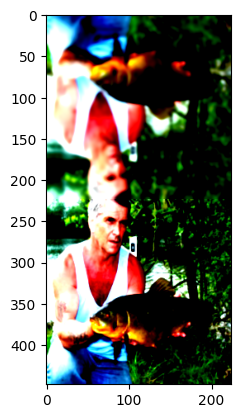

In [4]:
#plt.imshow(torch.permute(d[6][0], (1, 2, 0)))
#plt.show()
plt.imshow(torch.permute(d[6][0], (1, 2, 0)))
plt.show()

In [114]:
print(d[1][1])

torch.Size([3, 224, 224])
0


## Plot performance curves for each tiling

/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGresnet18_rep_1677500617.720859.pth.tar plotting 35
Namespace(arch='resnet18', batch_size=256, data='/scratch/gpfs/DATASETS/imagenet/ilsvrc_2012_classification_localization', data_rescale=1.0, dist_backend='nccl', dist_url='tcp://127.0.0.1:41201', distributed=True, dummy=False, epochs=36, evaluate=False, exp_name='AUGSTILINGresnet18_rep_1677500617.720859.pth.tar', gaussian_blur=True, gpu=0, growth_factor=1.0, image_transform_loader='TileImagenet', lr=0.1, max_sigma=2.0, momentum=0.9, multiprocessing_distributed=True, pretrained=False, print_freq=10, rank=0, resume='', save_dir='/scratch/gpfs/qanguyen/imagenet_info', scheduler_step_size=12, seed=None, start_epoch=0, tiling_imagenet='2,2', tiling_orientation_ablation=False, weight_decay=0.0001, workers=4, world_size=1, zero_out=None)
/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGresnet18_rep_1677494089.772057.pth.tar plotting 35
Namespace(arch='resnet18', batch_size=256, data='/scratch/gpfs/

/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGresnet18_rep_1677670119.262198.pth.tar plotting 31
Namespace(arch='resnet18', batch_size=256, data='/scratch/gpfs/DATASETS/imagenet/ilsvrc_2012_classification_localization', data_rescale=1.0, dist_backend='nccl', dist_url='tcp://127.0.0.1:54405', distributed=True, dummy=False, epochs=36, evaluate=False, exp_name='AUGSTILINGresnet18_rep_1677670119.262198.pth.tar', gaussian_blur=True, gpu=0, growth_factor=1.0, image_transform_loader='TileImagenet', lr=0.1, max_sigma=0.0, momentum=0.9, multiprocessing_distributed=True, pretrained=False, print_freq=10, rank=0, resume='', save_dir='/scratch/gpfs/qanguyen/imagenet_info', scheduler_step_size=12, seed=None, start_epoch=0, tiling_imagenet='3,2', tiling_orientation_ablation=False, weight_decay=0.0001, workers=4, world_size=1, zero_out=None)
/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGresnet18_rep_1677496748.690065.pth.tar plotting 35
Namespace(arch='resnet18', batch_size=256, data='/scratch/gpfs/

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


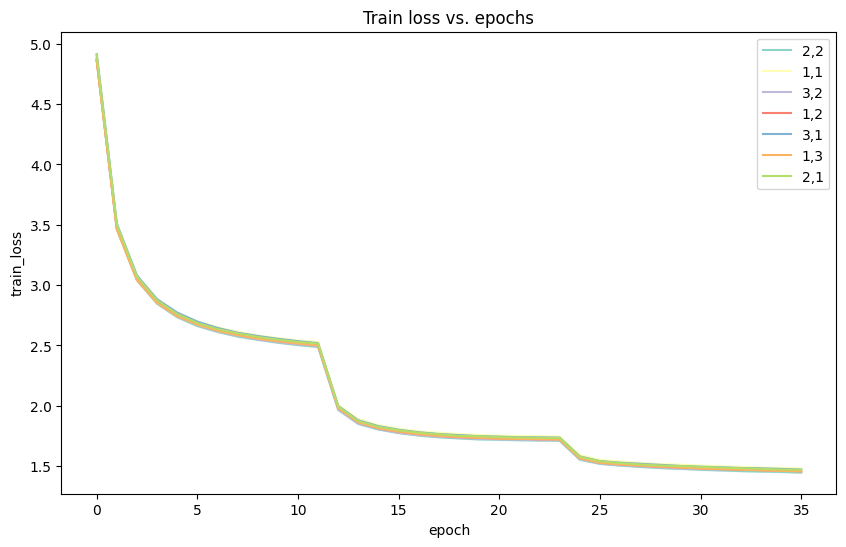

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:105: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


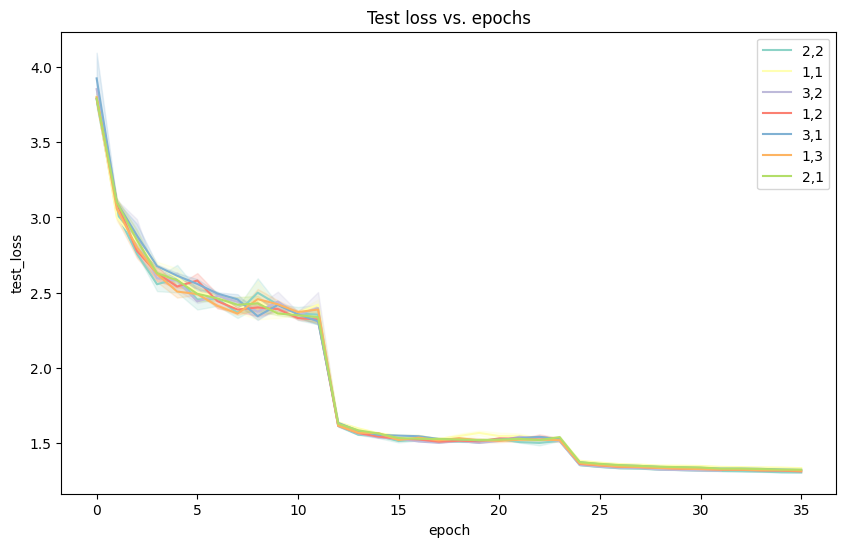

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


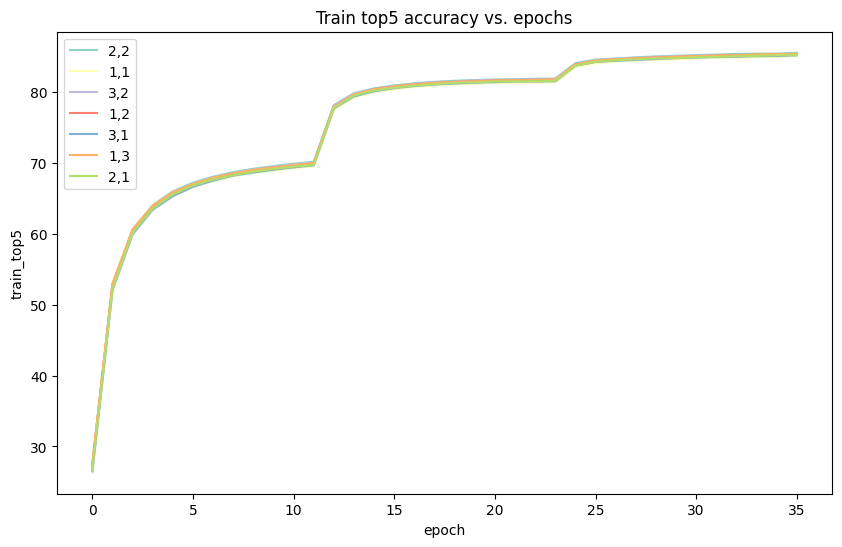

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


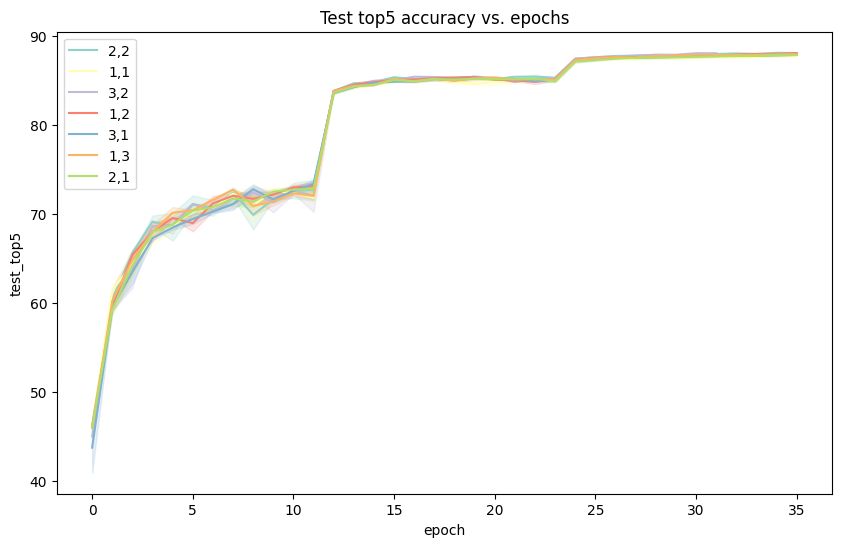

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


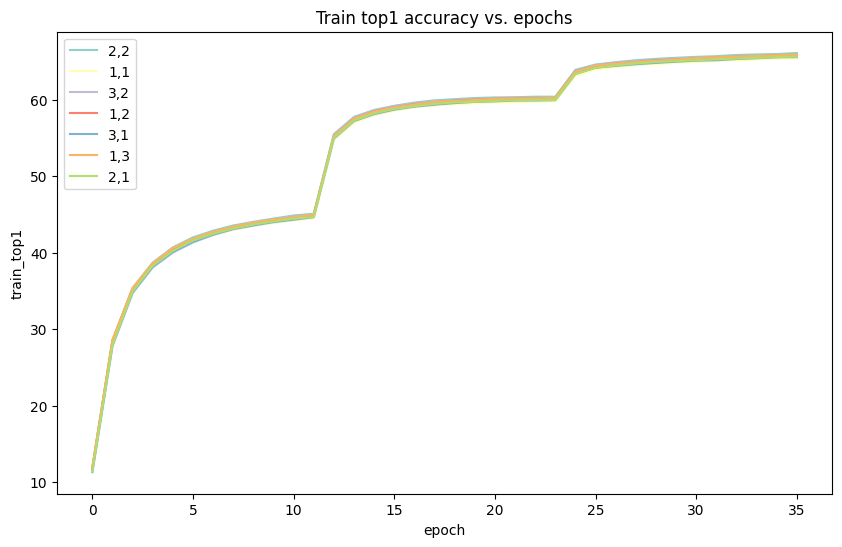

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:153: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


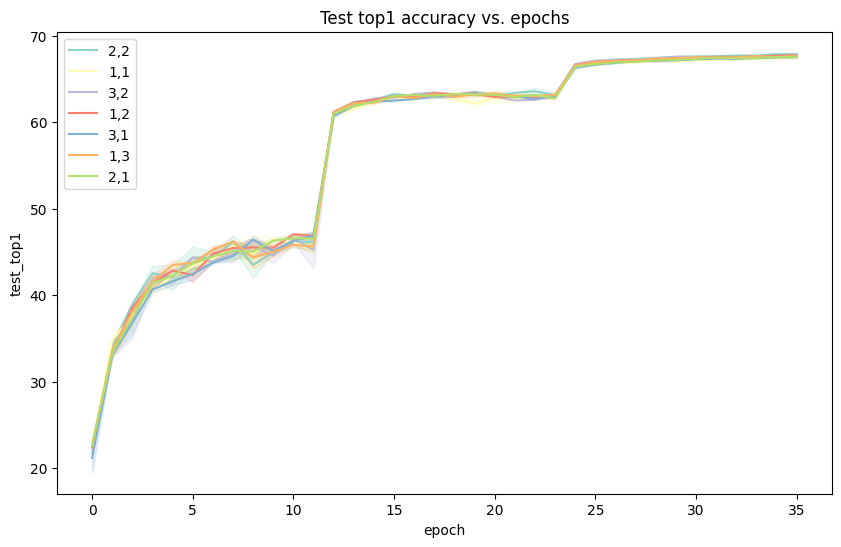

ValueError: Could not interpret value `epoch` for parameter `x`

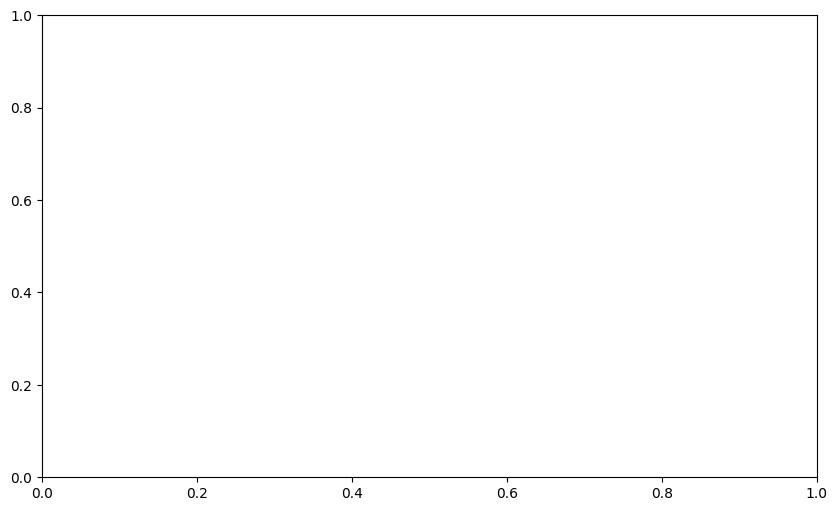

In [4]:
def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(order, is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale"
):
     
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = glob.glob(f"{outdir}/AUGSTILING*pth.tar")
    
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for f in record_names :
        
        try:
            
            record = torch.load(f) 
        except Exception as e: 
            print(e)
         
        try:
            if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
                continue
            if (image_transform_loader_list is not None) and (record.args.image_transform_loader not in image_transform_loader_list):
                continue
            if (tiling_orientation_ablation_list is not None) and (record.args.tiling_orientation_ablation not in tiling_orientation_ablation_list):
                continue
            if   hasattr(record.args, "num_models_ensemble"):
                print("Ensemble model")
                continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        print(f, "plotting", record.curr_epoch )
        print( record.args )
        for epoch in range(record.curr_epoch + 1):
                
            #pars["data_rescale"].append(record.data_rescale)
            pars["data_rescale"].append(record.args.growth_factor)
            pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            pars["epoch"].append(epoch)
            pars["train_loss"].append(record.metrics.train_losses[epoch])
            pars["test_loss"].append(record.metrics.val_losses[epoch])
            pars["train_top5"].append(record.metrics.train_acc5[epoch])
            pars["test_top5"].append(record.metrics.val_acc5[epoch])
            pars["train_top1"].append(record.metrics.train_acc1[epoch])
            pars["test_top1"].append(record.metrics.val_acc1[epoch])
            
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train loss vs. epochs")
    show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test loss vs. epochs")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top5 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top5acc_vs_epochs.png") 
   
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top5 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top5acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top1 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top1acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top1 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top1acc_vs_epochs.png")
 
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
# get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 32, 2), 
#            sample_strategy_list=["coefs"],
#            l1_listhttp://localhost:8072/notebooks/tensornetworks/generalization.ipynb# = None,
#            outdir = "/scratch/gpfs/qanguyen/poly_l1")

# get_record(model_name = "mlp_large", order = "*", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 62, 2), 
#            sample_strategy_list=["roots"],
#            l1_list = [0.0],
#            order_list = [3,4],
#            outdir = "/scratch/gpfs/qanguyen/poly_roots")
workdir = "/scratch/gpfs/qanguyen"
# workdir = "."
# get_record( order = "*",  
#            is_online=False, title = f"Imagenet loss, loss vs. data_rescale", 
#            outdir = f"{workdir}/imagenet_info",
#            zero_out_list = ["grow_from_center"],
#           hue_variable = "data_rescale"
#           ) 
get_record( order = "*",  
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale", 
           outdir = f"{workdir}/imagenet_info",
           zero_out_list = None,
           image_transform_loader_list = ['TileImagenet'],
           hue_variable = "tiling_imagenet",
           tiling_orientation_ablation_list = [False]
          ) 
get_record( order = "*",  
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale", 
           outdir = f"{workdir}/imagenet_info",
           zero_out_list = None,
           image_transform_loader_list = ['TileImagenet'],
           hue_variable = "tiling_imagenet",
           tiling_orientation_ablation_list = [True]
          ) 

/scratch/gpfs/qanguyen/imagenet_info/resnet18_rep_1676527502.698201.pth.tar plotting 15
/scratch/gpfs/qanguyen/imagenet_info/resnet18_rep_1676527551.23665.pth.tar plotting 9
/scratch/gpfs/qanguyen/imagenet_info/resnet18_rep_1676883331.911162.pth.tar plotting 2
/scratch/gpfs/qanguyen/imagenet_info/resnet18_rep_1676883310.408271.pth.tar plotting 3
Can't get attribute 'AverageMeter' on <module '__main__'>
/scratch/gpfs/qanguyen/imagenet_info/Ensembleresnet18_rep_1676872531.82149.pth.tar plotting 3
Can't get attribute 'AverageMeter' on <module '__main__'>
/scratch/gpfs/qanguyen/imagenet_info/Ensembleresnet18_rep_1676872644.100535.pth.tar plotting 3
Can't get attribute 'AverageMeter' on <module '__main__'>
/scratch/gpfs/qanguyen/imagenet_info/resnet18_rep_1676448467.943763.pth.tar plotting 3
/scratch/gpfs/qanguyen/imagenet_info/resnet18_rep_1676883310.479775.pth.tar plotting 2
Can't get attribute 'AverageMeter' on <module '__main__'>
/scratch/gpfs/qanguyen/imagenet_info/Ensembleresnet18_rep

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.


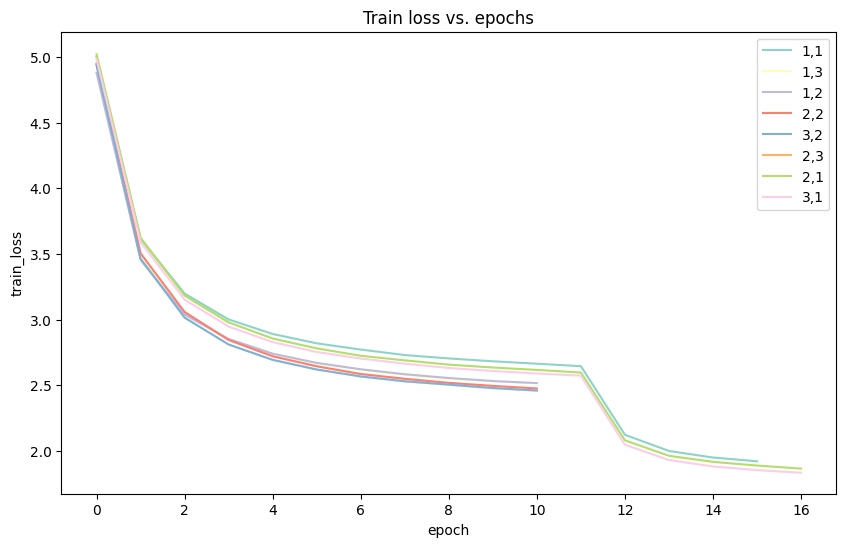

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.


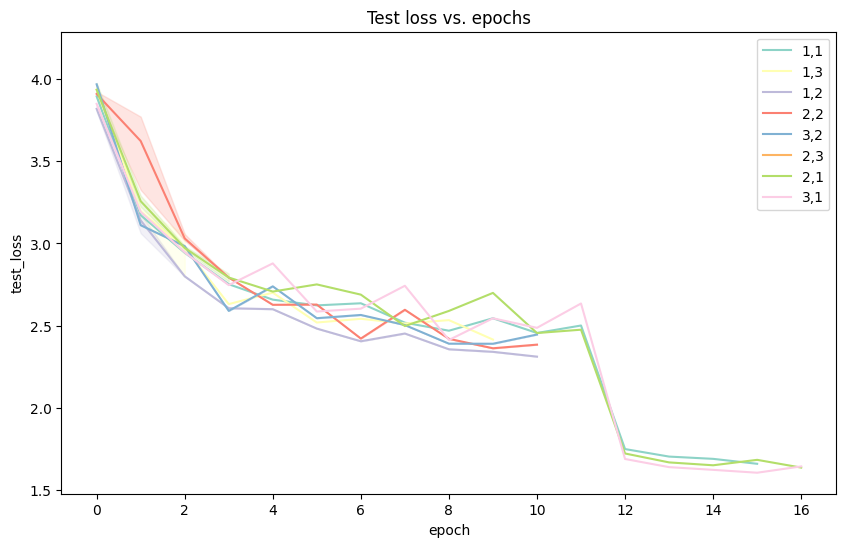

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.


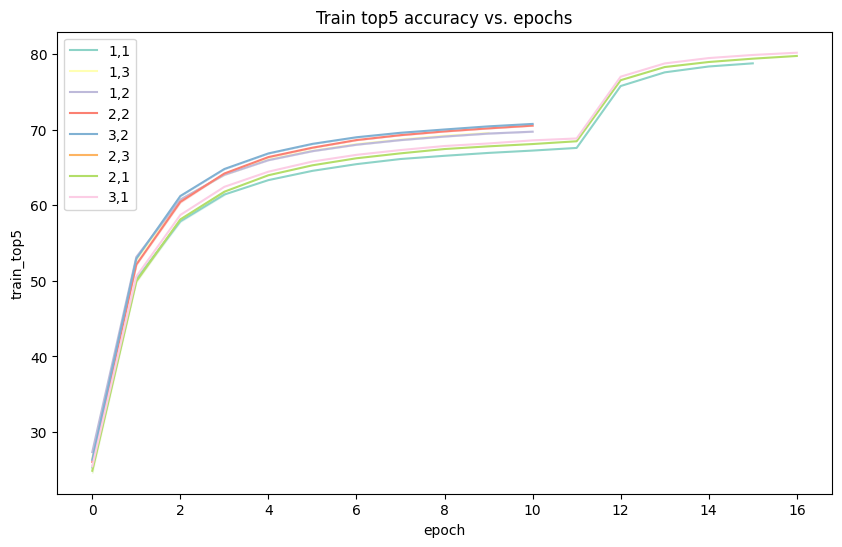

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.


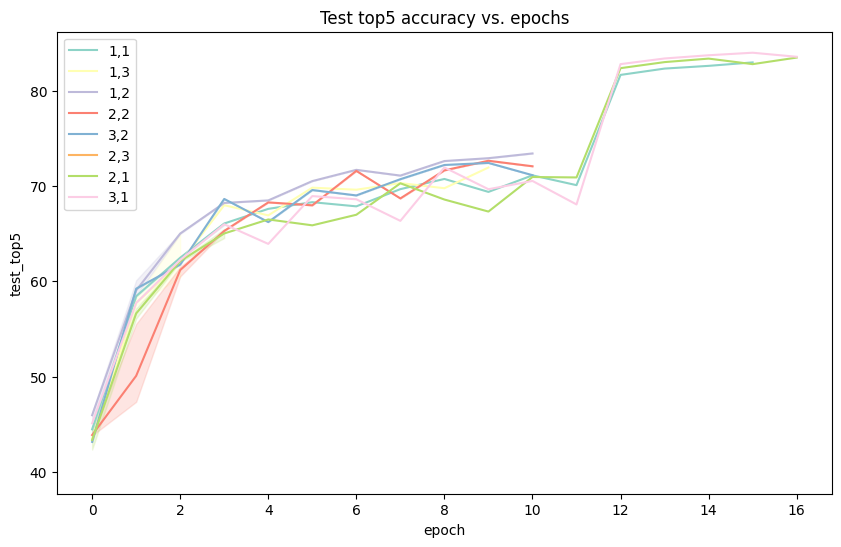

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.


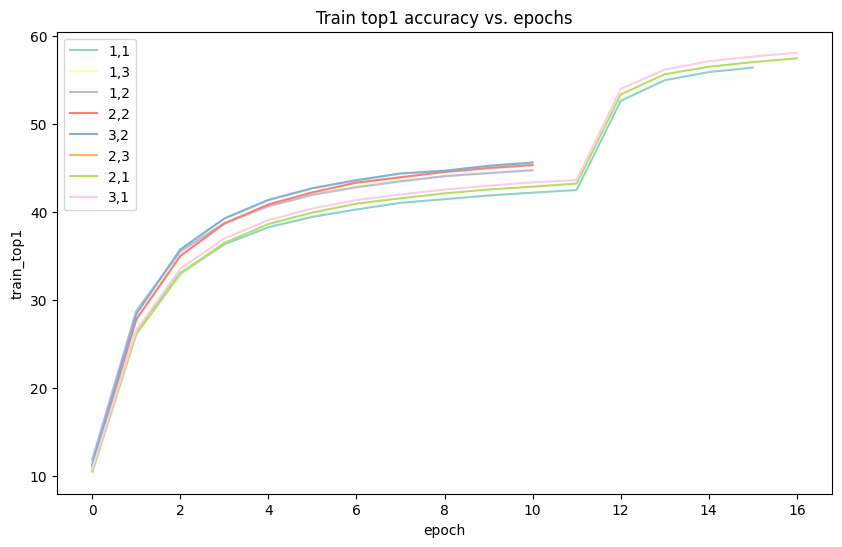

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:158: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.


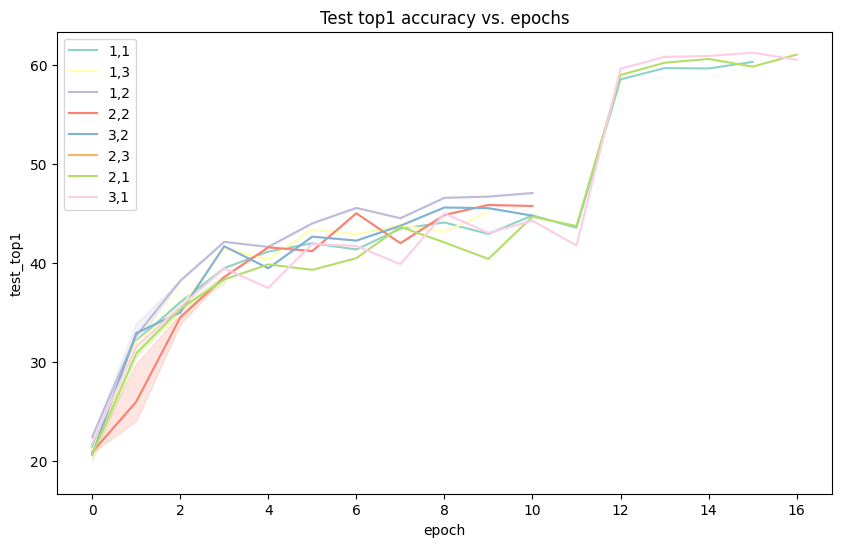

In [26]:
def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(order, is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
               max_sigma_list = None
):
     
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = glob.glob(f"{outdir}/*pth.tar")
    
    record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    record_included = [((r > 1675912720)) for r in record_included]
    record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for f in record_names :
        
        try:
            
            record = torch.load(f) 
        except Exception as e: 
            print(e)
        #print(record.args, "\n")
        try:
            if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
                continue
            if (image_transform_loader_list is not None) and (record.args.image_transform_loader not in image_transform_loader_list):
                continue
            if (tiling_orientation_ablation_list is not None) and (record.args.tiling_orientation_ablation not in tiling_orientation_ablation_list):
                continue
            if (max_sigma_list is not None) and (record.args.max_sigma not in max_sigma_list):
                continue
            if   hasattr(record.args, "num_models_ensemble"):
                print("Ensemble model")
                continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        print(f, "plotting", record.curr_epoch )
        for epoch in range(record.curr_epoch + 1):
                
            #pars["data_rescale"].append(record.data_rescale)
            pars["data_rescale"].append(record.args.growth_factor)
            try:
                pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            except:
                print("no tiling_imagenet in this run")
            pars["epoch"].append(epoch)
            pars["train_loss"].append(record.metrics.train_losses[epoch])
            pars["test_loss"].append(record.metrics.val_losses[epoch])
            pars["train_top5"].append(record.metrics.train_acc5[epoch])
            pars["test_top5"].append(record.metrics.val_acc5[epoch])
            pars["train_top1"].append(record.metrics.train_acc1[epoch])
            pars["test_top1"].append(record.metrics.val_acc1[epoch])
            
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train loss vs. epochs")
    show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test loss vs. epochs")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top5 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top5acc_vs_epochs.png") 
   
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top5 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top5acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top1 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top1acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top1 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top1acc_vs_epochs.png")
 
    
import warnings
 
workdir = "/scratch/gpfs/qanguyen"
 
get_record( order = "*",  
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale", 
           outdir = f"{workdir}/imagenet_info",
           zero_out_list = None,
           image_transform_loader_list = ['TileImagenet'],
           hue_variable = "tiling_imagenet",
           tiling_orientation_ablation_list = [True],
           max_sigma_list=[2.0] 
          ) 

In [7]:
for i, j in enumerate(data_loader):
    print(i)
    break

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 172, in default_collate
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 172, in <listcomp>
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 180, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


## Plot performance curves for a fixed tiling, augmentations vs. no augmentations

In [ ]:
def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(order, is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale"
):
     
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = glob.glob(f"{outdir}/AUGSTILINGr*pth.tar")
    
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for f in record_names :
        
        try:
            
            record = torch.load(f) 
        except Exception as e: 
            print(e)
         
        try:
            if record.curr_epoch < 27:
                continue
            if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
                continue
            if (image_transform_loader_list is not None) and (record.args.image_transform_loader not in image_transform_loader_list):
                continue
            if (tiling_orientation_ablation_list is not None) and (record.args.tiling_orientation_ablation not in tiling_orientation_ablation_list):
                continue
            if (tiling_list is not None) and (record.args.tiling_imagenet not in tiling_list):
                continue
            if   hasattr(record.args, "num_models_ensemble"):
                print("Ensemble model")
                continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        print(f, "plotting", record.curr_epoch )
        print( record.args )
        for epoch in range(record.curr_epoch + 1):
                
            #pars["data_rescale"].append(record.data_rescale)
            pars["data_rescale"].append(record.args.growth_factor)
            pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            pars["max_sigma"].append(f'max_sigma:{record.args.max_sigma},tile:{record.args.tiling_imagenet}')
            pars["epoch"].append(epoch)
            pars["train_loss"].append(record.metrics.train_losses[epoch])
            pars["test_loss"].append(record.metrics.val_losses[epoch])
            pars["train_top5"].append(record.metrics.train_acc5[epoch])
            pars["test_top5"].append(record.metrics.val_acc5[epoch])
            pars["train_top1"].append(record.metrics.train_acc1[epoch])
            pars["test_top1"].append(record.metrics.val_acc1[epoch])
            
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train loss vs. epochs")
    show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test loss vs. epochs")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top5 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top5acc_vs_epochs.png") 
   
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top5 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top5acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top1 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top1acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top1 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top1acc_vs_epochs.png")
 
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
# get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 32, 2), 
#            sample_strategy_list=["coefs"],
#            l1_listhttp://localhost:8072/notebooks/tensornetworks/generalization.ipynb# = None,
#            outdir = "/scratch/gpfs/qanguyen/poly_l1")

# get_record(model_name = "mlp_large", order = "*", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 62, 2), 
#            sample_strategy_list=["roots"],
#            l1_list = [0.0],
#            order_list = [3,4],
#            outdir = "/scratch/gpfs/qanguyen/poly_roots")
workdir = "/scratch/gpfs/qanguyen"
# workdir = "."
# get_record( order = "*",  
#            is_online=False, title = f"Imagenet loss, loss vs. data_rescale", 
#            outdir = f"{workdir}/imagenet_info",
#            zero_out_list = ["grow_from_center"],
#           hue_variable = "data_rescale"
#           ) 
# for tiling in ["1,1", "1,2", "1,3", "2,1", "2,2", "2,3", "3,1", "3,2", "3,3"]:
get_record( order = "*",  
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale", 
           outdir = f"{workdir}/imagenet_info",
           zero_out_list = None,
           image_transform_loader_list = ['TileImagenet'],
           hue_variable = "max_sigma",
           tiling_orientation_ablation_list = [False],
           tiling_list = ["1,1", "1,2", "1,3", "2,1", "2,2", "2,3", "3,1", "3,2", "3,3"]
          ) 

/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGresnet18_rep_1677500617.720859.pth.tar plotting 35
Namespace(arch='resnet18', batch_size=256, data='/scratch/gpfs/DATASETS/imagenet/ilsvrc_2012_classification_localization', data_rescale=1.0, dist_backend='nccl', dist_url='tcp://127.0.0.1:41201', distributed=True, dummy=False, epochs=36, evaluate=False, exp_name='AUGSTILINGresnet18_rep_1677500617.720859.pth.tar', gaussian_blur=True, gpu=0, growth_factor=1.0, image_transform_loader='TileImagenet', lr=0.1, max_sigma=2.0, momentum=0.9, multiprocessing_distributed=True, pretrained=False, print_freq=10, rank=0, resume='', save_dir='/scratch/gpfs/qanguyen/imagenet_info', scheduler_step_size=12, seed=None, start_epoch=0, tiling_imagenet='2,2', tiling_orientation_ablation=False, weight_decay=0.0001, workers=4, world_size=1, zero_out=None)
/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGresnet18_rep_1677494089.772057.pth.tar plotting 35
Namespace(arch='resnet18', batch_size=256, data='/scratch/gpfs/

## Plot performance curves Mar 7

/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGmar7resnet18_rep_1678264487.546449.pth.tar plotting 23
Namespace(arch='resnet18', batch_size=256, data='/scratch/gpfs/DATASETS/imagenet/ilsvrc_2012_classification_localization', data_rescale=1.0, dist_backend='nccl', dist_url='tcp://127.0.0.1:51005', distributed=True, dummy=False, epochs=24, evaluate=False, exp_name='AUGSTILINGmar7resnet18_rep_1678264487.546449.pth.tar', gaussian_blur=True, gpu=0, growth_factor=1.0, image_transform_loader='TileImagenet', lr=0.1, max_sigma=2.0, momentum=0.9, multiprocessing_distributed=True, pretrained=False, print_freq=10, rank=0, resume='', save_dir='/scratch/gpfs/qanguyen/imagenet_info', scheduler_step_size=8, seed=None, start_epoch=0, tiling_imagenet='2,1', tiling_orientation_ablation=False, weight_decay=0.0001, workers=4, world_size=1, zero_out=None)
/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGmar7resnet18_rep_1678359712.290909.pth.tar plotting 9
Namespace(arch='resnet18', batch_size=256, data='/scr

/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGmar7resnet18_rep_1678325331.0494.pth.tar plotting 7
Namespace(arch='resnet18', batch_size=256, data='/scratch/gpfs/DATASETS/imagenet/ilsvrc_2012_classification_localization', data_rescale=1.0, dist_backend='nccl', dist_url='tcp://127.0.0.1:46665', distributed=True, dummy=False, epochs=24, evaluate=False, exp_name='AUGSTILINGmar7resnet18_rep_1678325331.0494.pth.tar', gaussian_blur=True, gpu=0, growth_factor=1.0, image_transform_loader='TileImagenet', lr=0.1, max_sigma=2.0, momentum=0.9, multiprocessing_distributed=True, pretrained=False, print_freq=10, rank=0, resume='', save_dir='/scratch/gpfs/qanguyen/imagenet_info', scheduler_step_size=8, seed=None, start_epoch=0, tiling_imagenet='2,1', tiling_orientation_ablation=True, weight_decay=0.0001, workers=4, world_size=1, zero_out=None)
/scratch/gpfs/qanguyen/imagenet_info/AUGSTILINGmar7resnet18_rep_1678364774.292742.pth.tar plotting 2
Namespace(arch='resnet18', batch_size=256, data='/scratch/g

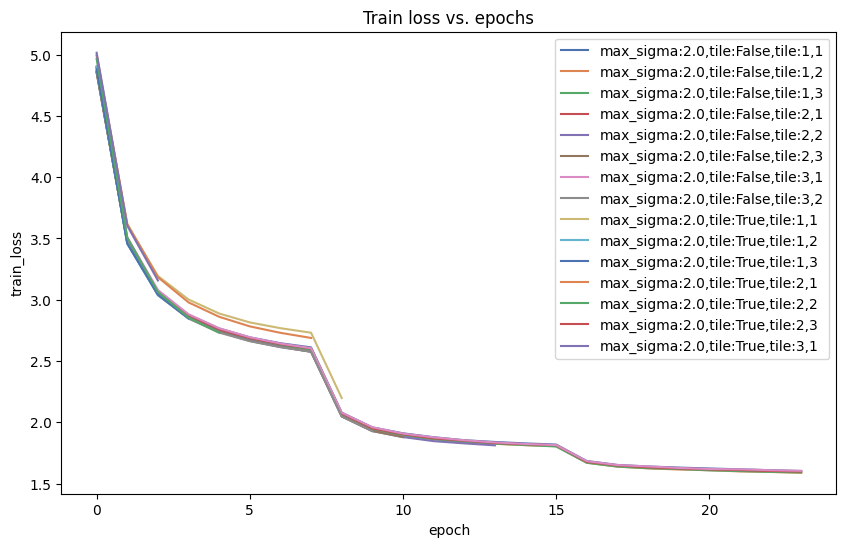

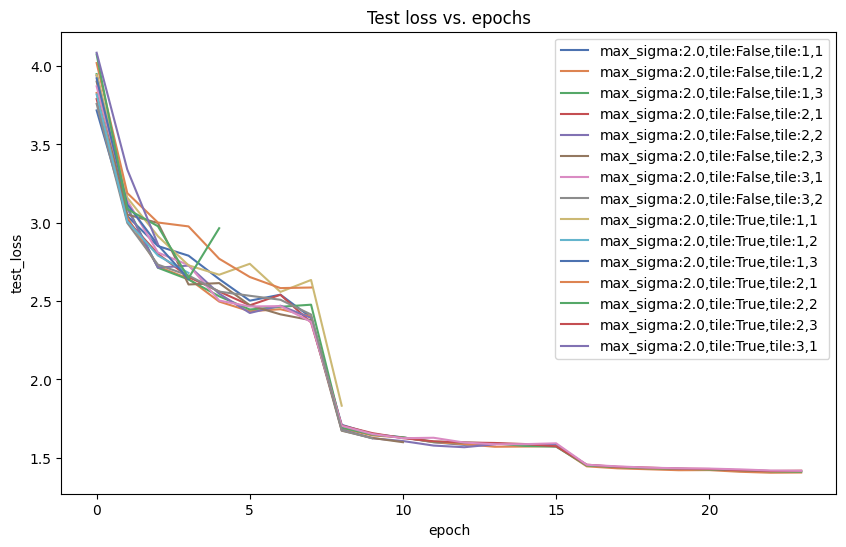

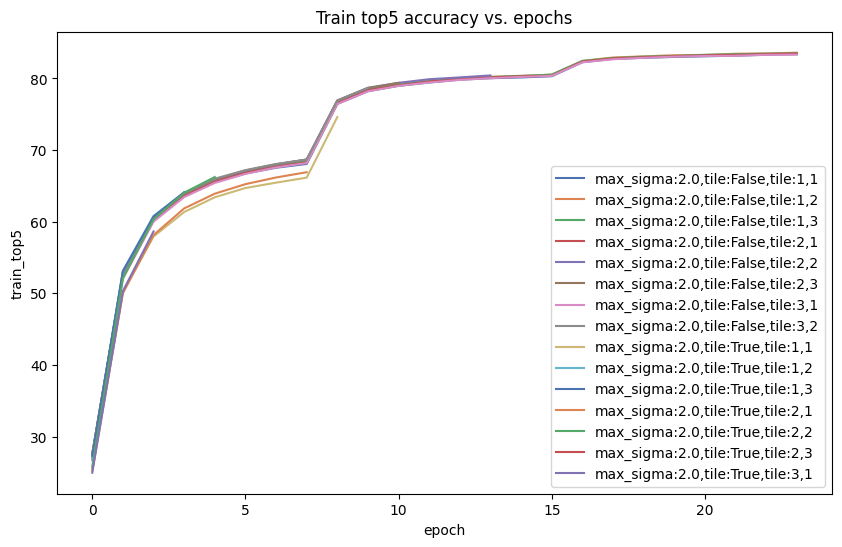

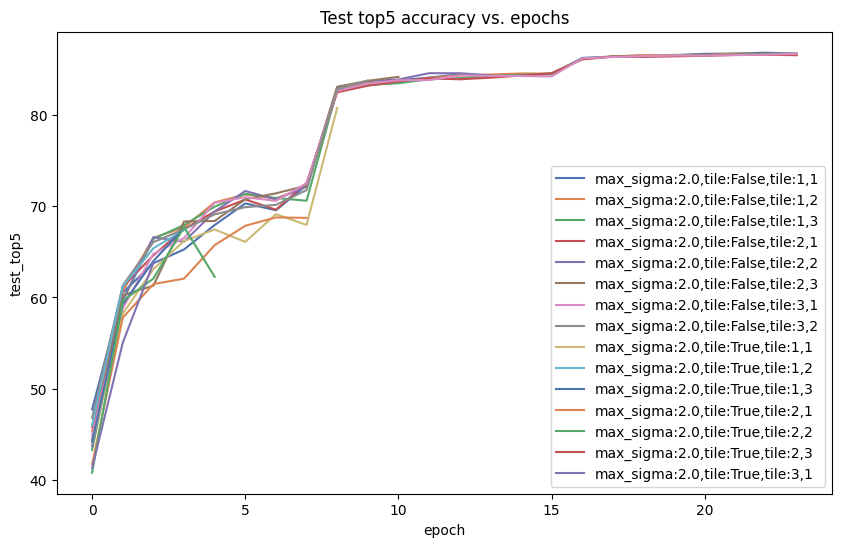

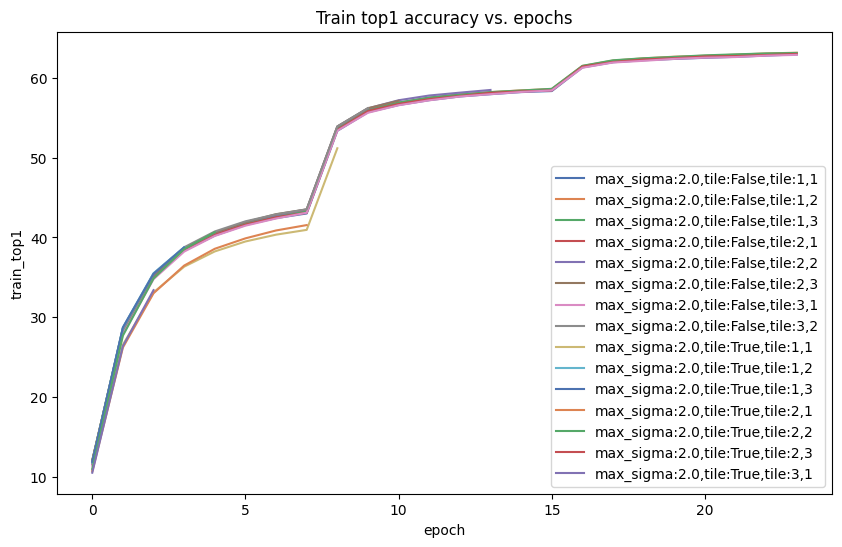

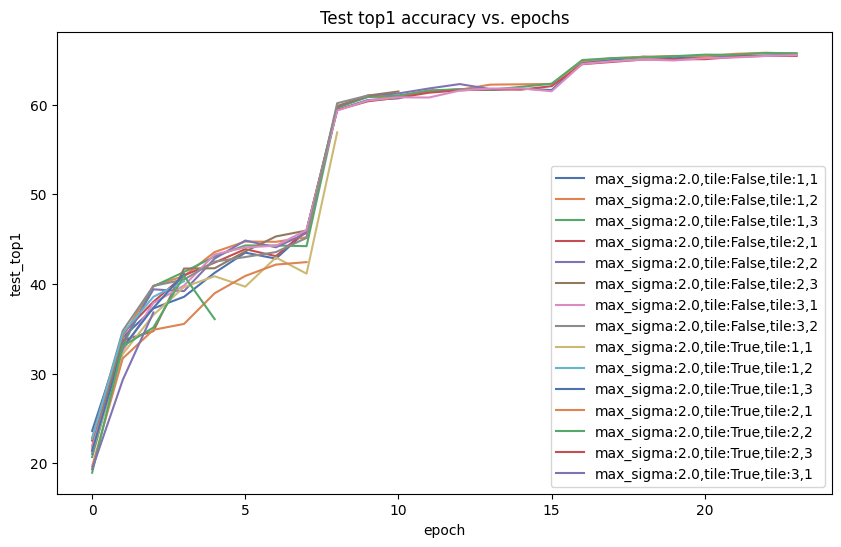

In [6]:
def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(order, is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               tiling_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale"
):
     
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = glob.glob(f"{outdir}/AUGSTILINGm*pth.tar")
    
    #record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    #record_included = [((r > 1675853450) and (r < 1675912720)) for r in record_included]
    #record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for f in record_names :
        
        try:
            
            record = torch.load(f) 
        except Exception as e: 
            print(e)
         
        try:
#             if record.curr_epoch < 27:
#                 continue
            if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
                continue
            if (image_transform_loader_list is not None) and (record.args.image_transform_loader not in image_transform_loader_list):
                continue
            if (tiling_orientation_ablation_list is not None) and (record.args.tiling_orientation_ablation not in tiling_orientation_ablation_list):
                continue
            if (tiling_list is not None) and (record.args.tiling_imagenet not in tiling_list):
                continue
            if   hasattr(record.args, "num_models_ensemble"):
                print("Ensemble model")
                continue
        except Exception as e: 
            print(e)
            print(f, "continue", record.curr_epoch )
            continue
        print(f, "plotting", record.curr_epoch )
        print( record.args )
        for epoch in range(record.curr_epoch + 1):
                
            #pars["data_rescale"].append(record.data_rescale)
            pars["data_rescale"].append(record.args.growth_factor)
            pars["tiling_imagenet"].append(record.args.tiling_imagenet)
            pars["max_sigma"].append(f'max_sigma:{record.args.max_sigma},tile:{record.args.tiling_orientation_ablation},tile:{record.args.tiling_imagenet}')
            pars["epoch"].append(epoch)
            pars["train_loss"].append(record.metrics.train_losses[epoch])
            pars["test_loss"].append(record.metrics.val_losses[epoch])
            pars["train_top5"].append(record.metrics.train_acc5[epoch])
            pars["test_top5"].append(record.metrics.val_acc5[epoch])
            pars["train_top1"].append(record.metrics.train_acc1[epoch])
            pars["test_top1"].append(record.metrics.val_acc1[epoch])
            
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    pars = pars.sort_values(by=hue_variable, ascending=True)

    sns.lineplot(x = "epoch", y="train_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train loss vs. epochs")
    show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    pars = pars.sort_values(by=hue_variable, ascending=True)
    sns.lineplot(x = "epoch", y="test_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test loss vs. epochs")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    pars = pars.sort_values(by=hue_variable, ascending=True)
    sns.lineplot(x = "epoch", y="train_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top5 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top5acc_vs_epochs.png") 
   
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    pars = pars.sort_values(by=hue_variable, ascending=True)
    sns.lineplot(x = "epoch", y="test_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top5 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top5acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    pars = pars.sort_values(by=hue_variable, ascending=True)
    sns.lineplot(x = "epoch", y="train_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top1 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top1acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    pars = pars.sort_values(by=hue_variable, ascending=True)
    sns.lineplot(x = "epoch", y="test_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top1 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top1acc_vs_epochs.png")
 
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
# get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 32, 2), 
#            sample_strategy_list=["coefs"],
#            l1_listhttp://localhost:8072/notebooks/tensornetworks/generalization.ipynb# = None,
#            outdir = "/scratch/gpfs/qanguyen/poly_l1")

# get_record(model_name = "mlp_large", order = "*", input_strategy_list=["random"], 
#            is_online=False, title = f"Polynomial regression loss, random inputs, final loss vs. num_inputs", 
#            num_inputs_list=np.arange(2, 62, 2), 
#            sample_strategy_list=["roots"],
#            l1_list = [0.0],
#            order_list = [3,4],
#            outdir = "/scratch/gpfs/qanguyen/poly_roots")
workdir = "/scratch/gpfs/qanguyen"
# workdir = "."
# get_record( order = "*",  
#            is_online=False, title = f"Imagenet loss, loss vs. data_rescale", 
#            outdir = f"{workdir}/imagenet_info",
#            zero_out_list = ["grow_from_center"],
#           hue_variable = "data_rescale"
#           ) 
# for tiling in ["1,1", "1,2", "1,3", "2,1", "2,2", "2,3", "3,1", "3,2", "3,3"]:
get_record( order = "*",  
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale",
           palette = sns.color_palette("deep", 15),
           outdir = f"{workdir}/imagenet_info",
           zero_out_list = None,
           image_transform_loader_list = ['TileImagenet'],
           hue_variable = "max_sigma",
           tiling_orientation_ablation_list = [True, False],
           tiling_list = ["1,1", "1,2", "1,3", "2,1", "2,2", "2,3", "3,1", "3,2", "3,3"]
          ) 

## Ensemble

In [2]:
from enum import Enum


class Summary(Enum):
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def all_reduce(self):
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        total = torch.tensor([self.sum, self.count], dtype=torch.float32, device=device)
        dist.all_reduce(total, dist.ReduceOp.SUM, async_op=False)
        self.sum, self.count = total.tolist()
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
    def summary(self):
        fmtstr = ''
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)
        
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries),flush=True)
        
    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        print(' '.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'




### Ensemble average softmax

/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_2_rep_1678051659.580238.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_2_rep_1678051659.580238.pth.tar plotting 7
args average_softmax
savedir /scratch/gpfs/qanguyen/imagenet_info
filename Ensemble36Epochsresnet18_num_ensemble_2_rep_1678051659.580238.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_5_rep_1678018167.261853.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_5_rep_1678018167.261853.pth.tar plotting 16
args average_softmax
savedir /scratch/gpfs/qanguyen/imagenet_info
filename Ensemble36Epochsresnet18_num_ensemble_5_rep_1678018167.261853.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_1_rep_1678062092.624003.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_1_rep_1678062092.624003.pth.tar plotting 3
args average_softmax
savedir /scra

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


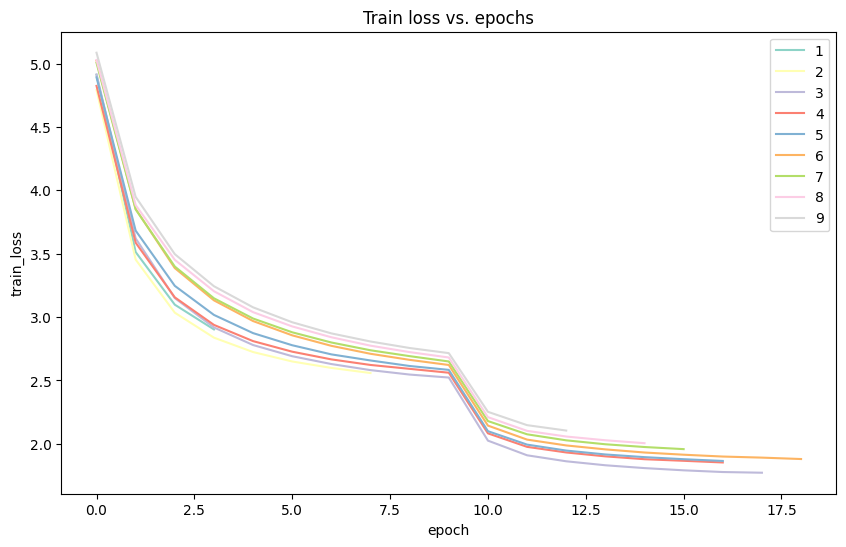

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


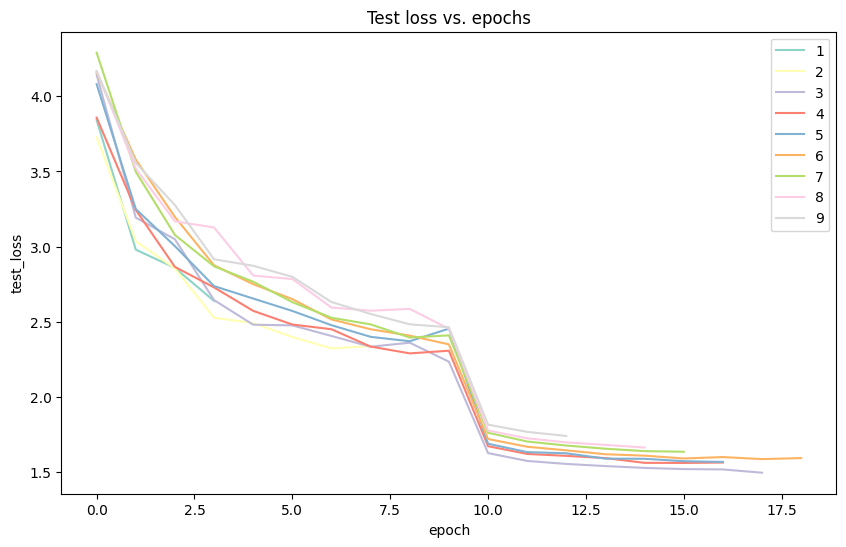

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


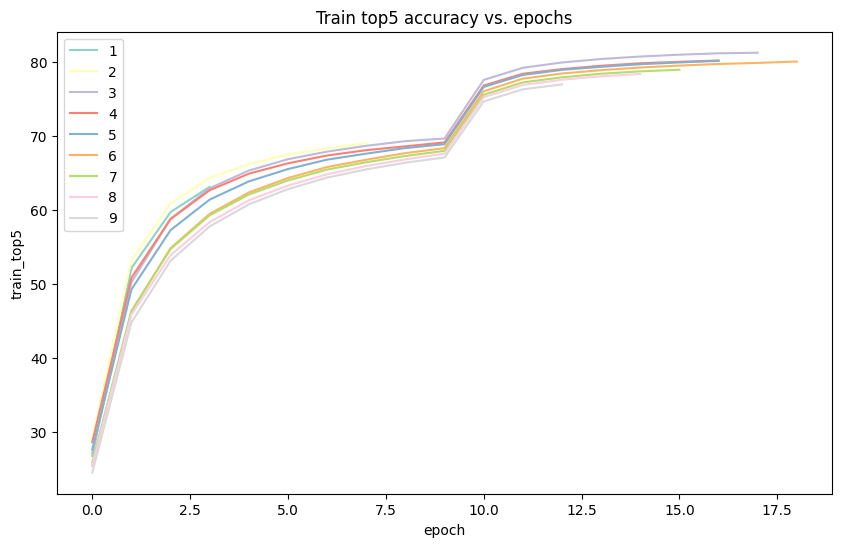

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


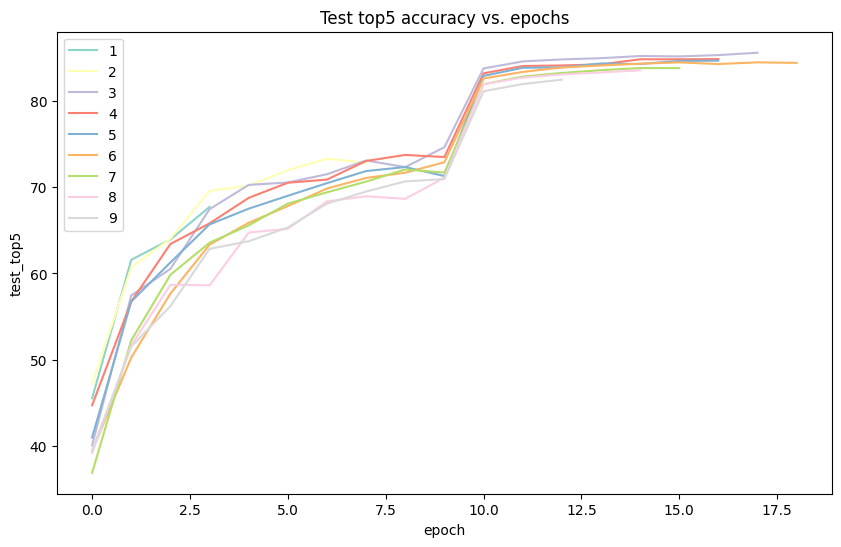

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


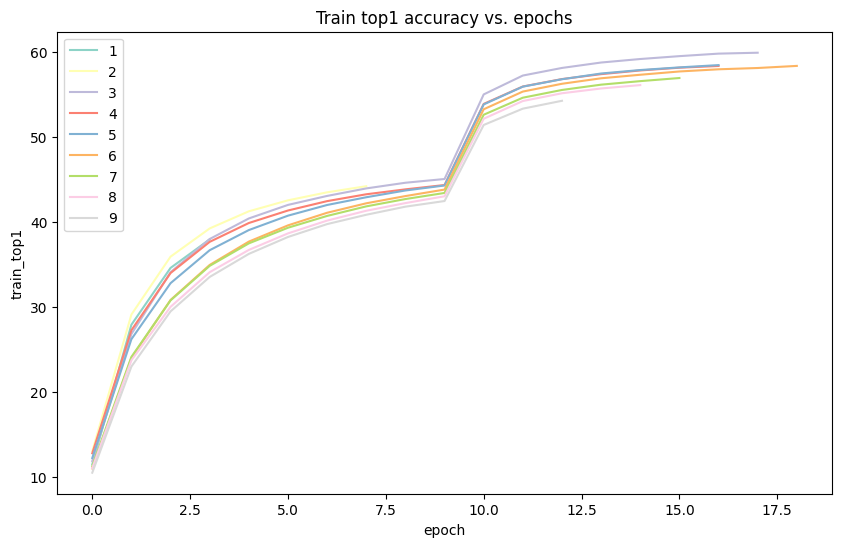

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:158: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


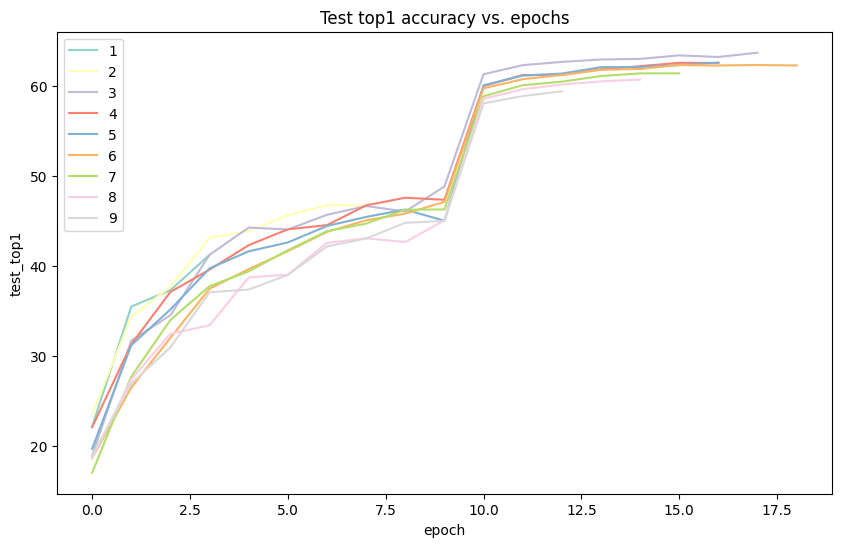

In [8]:


def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(order, is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
):
     
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = glob.glob(f"{outdir}/Ensemble36*pth.tar")
    
    record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    record_included = [((r > 1678000000) and (r < 1678062095)) for r in record_included]
    record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for f in record_names :
        print(f)
        try:
            
            record = torch.load(f) 
        except Exception as e: 
            print(e)
        #print(record.args, "\n")
        try:
            #if record.curr_epoch <= 5:
            #    continue
            if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
                continue
            if (image_transform_loader_list is not None) and (record.args.image_transform_loader not in image_transform_loader_list):
                continue
            if  not hasattr(record.args, "num_models_ensemble"):
                print("Not Ensemble model")
                continue
        except Exception as e: 
            print(e)
            print(f, "continue")
            continue
        print(f, "plotting", record.curr_epoch )
        print("args", record.args.voting_strategy)
        for epoch in range(record.curr_epoch + 1):
            pars["epoch"].append(epoch)
            pars["num_models_ensemble"].append(record.args.num_models_ensemble)
            pars["train_loss"].append(record.metrics.train_losses[epoch])
            pars["test_loss"].append(record.metrics.val_losses[epoch])
            pars["train_top5"].append(record.metrics.train_acc5[epoch])
            pars["test_top5"].append(record.metrics.val_acc5[epoch])
            pars["train_top1"].append(record.metrics.train_acc1[epoch])
            pars["test_top1"].append(record.metrics.val_acc1[epoch])
            
            
        
         
        print("savedir", record.args.save_dir)
        print("filename", record.args.exp_name)
         
        #utils.save_checkpoint(record_weights, save_dir = record.args.save_dir, filename = f"weights_{record.args.exp_name}")
        del record
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train loss vs. epochs")
    show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test loss vs. epochs")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top5 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top5acc_vs_epochs.png") 
   
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top5 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top5acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top1 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top1acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top1 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top1acc_vs_epochs.png")
 
    
import warnings
 
workdir = "/scratch/gpfs/qanguyen"
 
get_record( order = "*",  
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale", 
           outdir = f"{workdir}/imagenet_info",
           zero_out_list = None,
           image_transform_loader_list = ['TileImagenet'],
           hue_variable = "num_models_ensemble",
           tiling_orientation_ablation_list = [True],
          ) 

### Ensemble average logits

/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_7_rep_1678169680.548386.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_7_rep_1678169680.548386.pth.tar plotting 15 average_logits
savedir /scratch/gpfs/qanguyen/imagenet_info
filename Ensemble36Epochsresnet18_num_ensemble_7_rep_1678169680.548386.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_9_rep_1678169626.447761.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_9_rep_1678169626.447761.pth.tar plotting 12 average_logits
savedir /scratch/gpfs/qanguyen/imagenet_info
filename Ensemble36Epochsresnet18_num_ensemble_9_rep_1678169626.447761.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_4_rep_1678169725.551801.pth.tar
/scratch/gpfs/qanguyen/imagenet_info/Ensemble36Epochsresnet18_num_ensemble_4_rep_1678169725.551801.pth.tar plotting 21 average_logits
savedir /scratch/gpfs/qanguye

epoch  num_models_ensemble  train_loss  test_loss  train_top5  test_top5  \
0        0                    7    4.776750   3.608536   29.149674     49.234   
1        1                    7    3.307544   2.779464   56.027587     65.446   
2        2                    7    2.861761   2.515778   64.083486     69.846   
3        3                    7    2.657550   2.332280   67.617290     73.174   
4        4                    7    2.540539   2.277631   69.595823     73.942   
..     ...                  ...         ...        ...         ...        ...   
123     14                    6    1.657720   1.419654   82.904739     86.626   
124     15                    6    1.642149   1.406951   83.135641     86.914   
125     16                    6    1.534595   1.313668   84.569684     88.154   
126     17                    6    1.507083   1.302512   84.959172     88.364   
127     18                    6    1.490358   1.296305   85.193165     88.372   

     train_top1  test_top1  
0     12.996979     25.158  
1     31.245809     38.878  
2     38.794630     43.286  
3     42.489933     47.050  
4     44.639926     47.622  
..          ...        ...  
123   62.191886     65.518  
124   62.501092     65.756  
125   64.895278     67.690  
126   65.477291     68.036  
127   65.808089     68.098  

[128 rows x 8 columns]

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


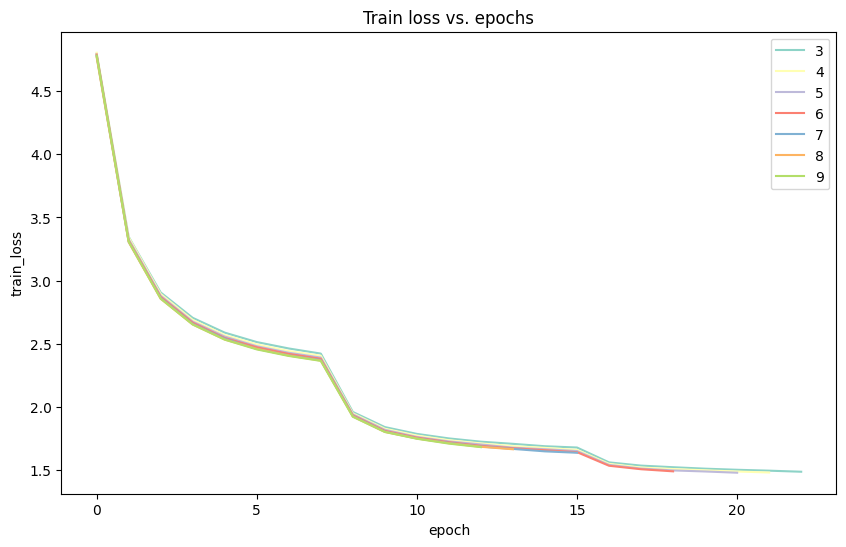

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


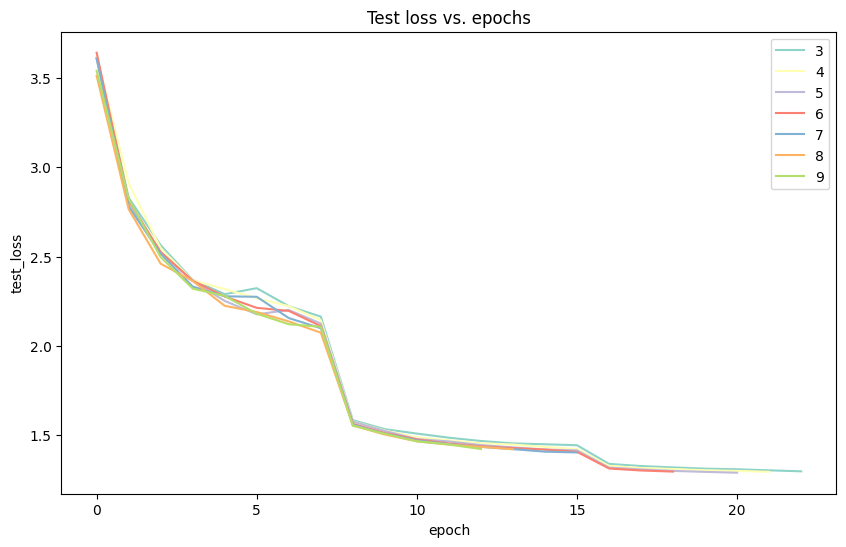

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:123: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


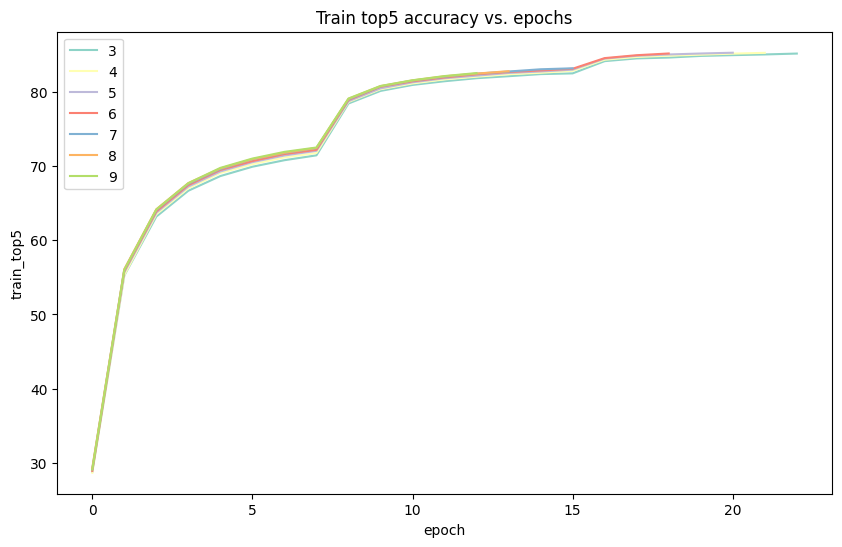

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:135: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


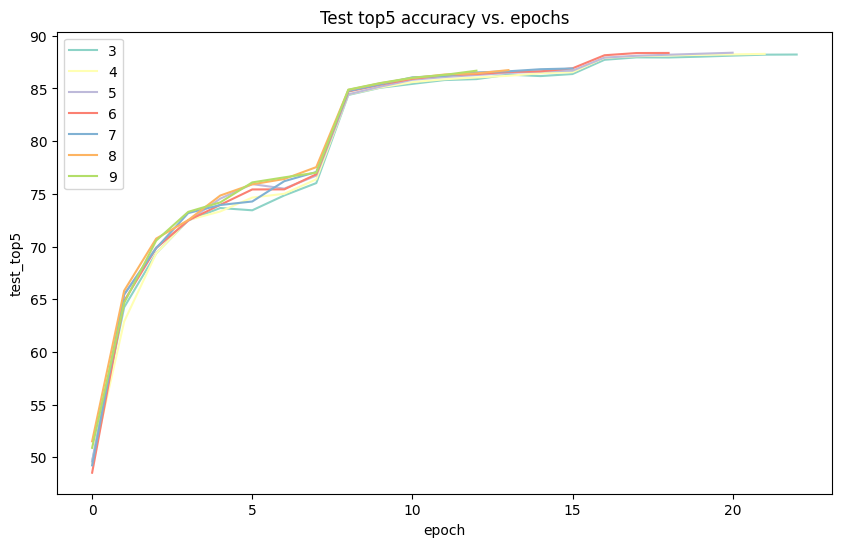

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


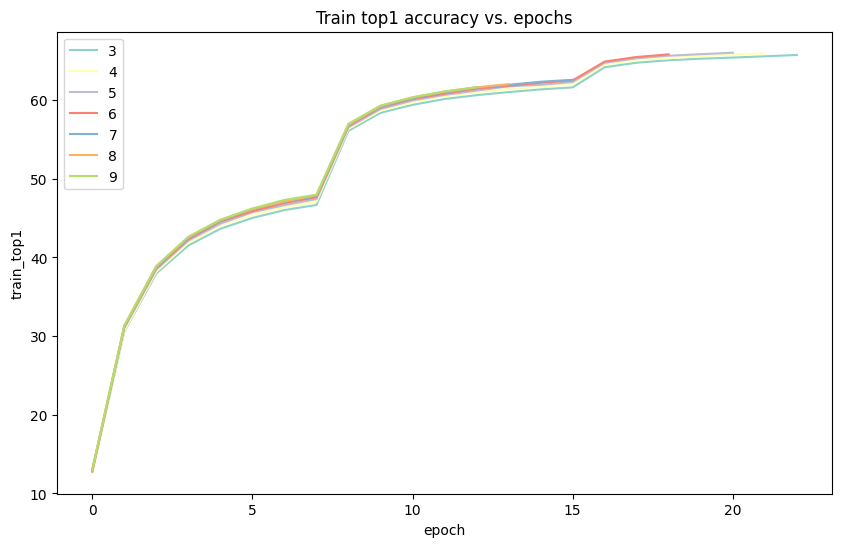

/home/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:159: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.


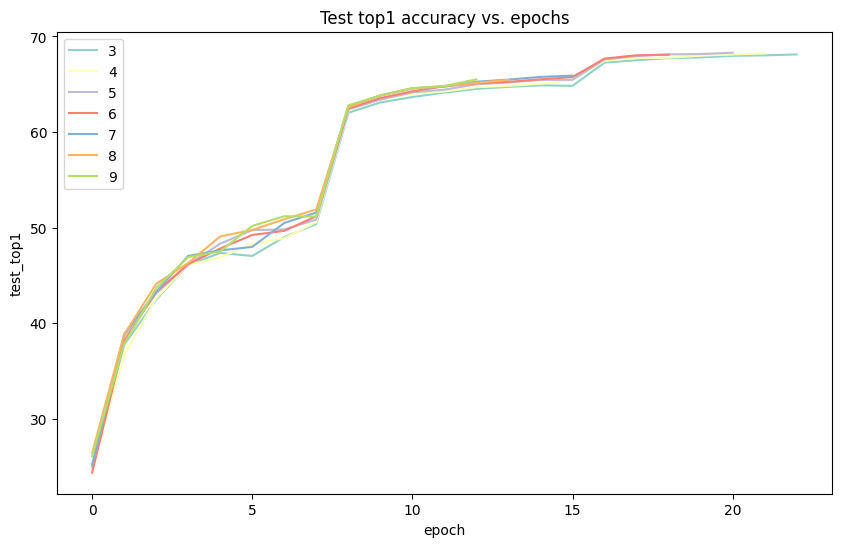

In [3]:


def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True

def show_plt_if_in_notebook(title=None):
    if in_notebook():
        plt.show()
    else:
        plt.savefig(title)
def get_record(order, is_online, extra = "", title = None,  
               zero_out_list = None,
               image_transform_loader_list = None,
               tiling_orientation_ablation_list = None,
               outdir = "/scratch/gpfs/qanguyen/poly1/",
              palette = sns.color_palette("Set3", 10),
               hue_variable = "data_rescale",
):
     
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    #record_names = ['resnet18_rep_1673625625.387933.pkl', 'resnet18_rep_1673618285.140812.pkl', 
    #               'resnet18_rep_1673618285.124871.pkl', 'resnet18_rep_1673618315.142802.pkl',
    #               'resnet18_rep_1673618403.386129.pkl', 'resnet18_rep_1673618403.386123.pkl',
    #               'resnet18_rep_1673618381.887423.pkl', 'resnet18_rep_1673618474.561327.pkl',
    #               'resnet18_rep_1673625654.48548.pkl', 'resnet18_rep_1673614260.528039.pkl']
    
#     record_names = ['resnet18_rep_1673873160.304721.pkl', 'resnet18_rep_1673873238.133468.pkl',
#                   'resnet18_rep_1673873238.273423.pkl', 'resnet18_rep_1673873237.417957.pkl',
#                   'resnet18_rep_1673873267.69003.pkl', 'resnet18_rep_1673873267.029088.pkl',
#                   'resnet18_rep_1673873267.064156.pkl', 'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = ['resnet18_rep_1674056611.865267.pkl', 'resnet18_rep_1674056612.392694.pkl',
                  'resnet18_rep_1674056625.227239.pkl', 'resnet18_rep_1674057094.9487.pkl',
                  'resnet18_rep_1674058958.82337.pkl', 'resnet18_rep_1674059096.368824.pkl',
                  'resnet18_rep_1674059129.166538.pkl']#, 
#                     'resnet18_rep_1673873329.711897.pkl',
#                   'resnet18_rep_1673873329.711921.pkl', 'resnet18_rep_1673873376.545421.pkl']
    record_names = glob.glob(f"{outdir}/Ensemble36*pth.tar")
    
    record_included = [int(r.split("_")[-1].split(".")[0]) for r in record_names]
    record_included = [((r > 1678169000)) for r in record_included]
    record_names = [ r for i,r in enumerate(record_names) if record_included[i] == True]
    #print(record_names, len(record_names))
    for f in record_names :
        print(f)
        try:
            
            record = torch.load(f) 
        except Exception as e: 
            print(e)
        #print(record.args, "\n")
        try:
            #if record.curr_epoch <= 5:
            #    continue
            if (zero_out_list is not None) and (record.args.zero_out not in zero_out_list):
                continue
            if (image_transform_loader_list is not None) and (record.args.image_transform_loader not in image_transform_loader_list):
                continue
            if  not hasattr(record.args, "num_models_ensemble"):
                print("Not Ensemble model")
                continue
        except Exception as e: 
            print(e)
            print(f, "continue")
            continue
        print(f, "plotting", record.curr_epoch, record.args.voting_strategy )
        for epoch in range(record.curr_epoch + 1):
            pars["epoch"].append(epoch)
            pars["num_models_ensemble"].append(record.args.num_models_ensemble)
            pars["train_loss"].append(record.metrics.train_losses[epoch] )
            pars["test_loss"].append(record.metrics.val_losses[epoch] )
            pars["train_top5"].append(record.metrics.train_acc5[epoch] )
            pars["test_top5"].append(record.metrics.val_acc5[epoch] )
            pars["train_top1"].append(record.metrics.train_acc1[epoch] )
            pars["test_top1"].append(record.metrics.val_acc1[epoch] )
            
            
        
         
        print("savedir", record.args.save_dir)
        print("filename", record.args.exp_name)
         
        #utils.save_checkpoint(record_weights, save_dir = record.args.save_dir, filename = f"weights_{record.args.exp_name}")
        # del record
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    display(pars)
    sns.lineplot(x = "epoch", y="train_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train loss vs. epochs")
    plt.show()
#     show_plt_if_in_notebook("train_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_loss", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test loss vs. epochs")
    show_plt_if_in_notebook("test_loss_vs_epochs.png")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top5 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top5acc_vs_epochs.png") 
   
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top5", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top5 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top5acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="train_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Train top1 accuracy vs. epochs")
    show_plt_if_in_notebook("train_top1acc_vs_epochs.png")
 
    fig, ax = plt.subplots(figsize=(10, 6))
    pars = pd.DataFrame.from_dict(pars) 
    sns.lineplot(x = "epoch", y="test_top1", 
                  hue=hue_variable,
                 palette = palette, data=pars  )
 
    #ax.set(yscale="log")
    plt.legend()
    #plt.ylim(1e-4, 5.5)
    plt.title("Test top1 accuracy vs. epochs")
    show_plt_if_in_notebook("test_top1acc_vs_epochs.png")
 
    
import warnings
 
workdir = "/scratch/gpfs/qanguyen"
 
get_record( order = "*",  
           is_online=False, title = f"Imagenet loss, loss vs. data_rescale", 
           outdir = f"{workdir}/imagenet_info",
           zero_out_list = None,
           image_transform_loader_list = ['TileImagenet'],
           hue_variable = "num_models_ensemble",
           tiling_orientation_ablation_list = [True],
          ) 